In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# NOTEBOOK IMPORTS
import os, glob, warnings, pickle, re, traceback
import numpy as np
from shutil import copyfile
from datetime import datetime
from fuzzywuzzy import process
import easyocr

# IMAGE IMPORTS
from PIL import Image
import cv2

# GIS IMPORTS
from affinetransformation import *
from affine import Affine
import pandas as pd
import geopandas as gpd
import rasterio as rio

# IMAGE IMPORTS
# from skimage.morphology import skeletonize
# from skimage import img_as_bool, img_as_ubyte


# PLOTTING IMPORTS
import matplotlib.pyplot as plt

# CUSTOM UTILITIES
from IndexUtils import * 
from TileUtils import *
from TileNameFinder import *
from ReadDate import *
from featurematching import *

Image.MAX_IMAGE_PIXELS = 933120000
warnings.filterwarnings("ignore")
initialize = False

%matplotlib widget

c:\Users\fhacesga\Anaconda3\envs\yolo\lib\site-packages\geopandas\_compat.py:124: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
C:\Users\fhacesga\AppData\Local\Temp\ipykernel_25116\1811205482.py:17: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. 

WARNING  Python>=3.10 is required, but Python==3.8.18 is currently installed 


IO directories depending on which machine. 

In [3]:
username = os.getlogin()

dnn_params = {}
dnn_params['CLNN'] = {}
dnn_params['TPNN'] = {}
dnn_params['RLNN'] = {}
dnn_params['FLNN'] = {}
dnn_params['TLNN'] = {}


if username == 'fhacesga':
    base_input_path   = r"D:\RECTDNN\uncompress_2\\"
    base_output_path  = r"D:\RECTDNN\processing\\"
    ref_dir  = r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\AAA_ReferenceDatasets\\"
    tiled_yolo_model_paths = [
        r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\CORNERS\CornersTiled_111324.pt",
        r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\FANN\FANN_large_YOLO.pt"
    ]
elif username == 'fhace':
    base_input_path   = r"C:\Users\fhace\Desktop\FIRMs\data\Uncompress\\"
    ref_dir = r"C:\Users\fhace\Desktop\FIRMs\data\AAA_ReferenceDatasets\\"
    base_output_path = r"C:\Users\fhace\Desktop\FIRMs\data\Outputs\\"
    # dnn_params['TLNN']['model_weights']    = r"C:\Users\fhace\Desktop\FIRMs\data\BBNN\curr_weights.pt"
    dnn_params['CLNN']['model_checkpoint'] = r"C:\Users\fhace\Desktop\FIRMs\data\RLNN\checkpoint_101423.pth"
    dnn_params['TPNN']['model_checkpoint'] = r"C:\Users\fhace\OneDrive - University Of Houston\AAA_RECTDNN\data\TPNN\checkpoint_091523_pyramids_2.pth"
    dnn_params['RLNN']['model_checkpoint'] = r"C:\Users\fhace\OneDrive - University Of Houston\AAA_RECTDNN\data\RLNN\checkpoint_091323.pth"
    
else:
    base_input_path   = r"D:\Desktop\FIRMsDigitizing\data\HistoricalFIRMS"
    base_output_path  = r"D:\Desktop\FIRMsDigitizing\processing"
    ref_dir  = r"C:\Users\franc\OneDrive - University Of Houston\AAA_RECTDNN\data\AAA_ReferenceDatasets\\"

if not initialize:
    initialize = init_databases(ref_dir)

try:
    reader
except:
    reader = easyocr.Reader(['en']) 

In [4]:
proc_dir = r"C:\Users\fhacesga\OneDrive - University Of Houston\000_FIRMsPaper\Validation\input_data\RegTiles\run\\"

For each image we are processing, identify street corners

In [5]:
tiles = glob.glob(proc_dir + "tiles_goodstreets\*.tif")

In [6]:
out = processTiledYOLOs(tiles, tiled_yolo_model_paths, ['CornerCoordinates', 'street_corners'], proc_dir, imsizes=[256, 320])

Making images half size for tiled inference


  0%|          | 0/5 [00:00<?, ?it/s]

Reading from C:\Users\fhacesga\OneDrive - University Of Houston\000_FIRMsPaper\Validation\input_data\RegTiles\run\\CornerCoordinates.pkl
Reading from C:\Users\fhacesga\OneDrive - University Of Houston\000_FIRMsPaper\Validation\input_data\RegTiles\run\\street_corners.pkl


In [7]:
cornercoords_dict = out[0]
streetcorner_dict = out[1]

In [8]:
corners     = gpd.read_file(r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\AAA_ReferenceDatasets\OSM_Roads\TexasRoads_filtered_strict_3857_nondupe_smaller_harris.gpkg")
roads_gdf   = gpd.read_file(r"C:\Users\fhacesga\Downloads\TexasRoads_filtered_strict_3857.gpkg", engine='pyogrio', use_arrow=True)

In [9]:
corner_dir = os.path.join(get_largest_subdirectory(os.path.join(proc_dir, "street_corners")), "pickles")

if os.path.isdir(os.path.join(proc_dir, "focus")):
    referencing_dir  =  os.path.join(proc_dir, "focus") + "\\"
    print(f"Focus found, using {referencing_dir}")

registration_dir = os.path.join(proc_dir, "registration")
os.makedirs(registration_dir, exist_ok=True)

print(corner_dir)

C:\Users\fhacesga\OneDrive - University Of Houston\000_FIRMsPaper\Validation\input_data\RegTiles\run\\street_corners\exp2\pickles


In [10]:
np.set_printoptions(precision=8) 

In [11]:
def normCoords(A, B):
    offsets = np.min(A, axis=0)
    return A - offsets, B - offsets

def updateResults(list1, list2, verbose=False):
    combined_dict = {}
    all_matches = list1 + list2

    if not all_matches:
        return []

    # Check data format (tuple vs dict)
    is_dict_format = isinstance(all_matches[0], dict)

    for entry in all_matches:
        if is_dict_format:
            key = entry["real_idx"]
            d1, d2 = entry["d1"], entry["d2"]
        else:
            key = entry[0]
            d1, d2 = entry[2], entry[3]

        try:
            current_ratio = d1 / d2
        except ZeroDivisionError:
            continue

        if key not in combined_dict:
            combined_dict[key] = entry
        else:
            prev = combined_dict[key]
            prev_ratio = (prev["d1"] / prev["d2"]) if is_dict_format else (prev[2] / prev[3])
            if current_ratio < prev_ratio:
                combined_dict[key] = entry

    combined_list = list(combined_dict.values())
    if verbose:
        print("Results Update:", len(list1), len(list2), len(combined_list))
    return combined_list
def most_popular_indices_2d_flexible(uv_vectors, eps=0.1, iteration=0, n_iters=10, min_cluster_size=10):
    """
    uv_vectors: np.ndarray of shape (N, 2) representing delta vectors (dx, dy)
    eps: base clustering threshold (in normalized space)
    iteration: current iteration index (0-based)
    n_iters: total iterations expected
    """
    # Compute angle and magnitude
    angles = np.degrees(np.arctan2(uv_vectors[:, 1], uv_vectors[:, 0])) % 360
    magnitudes = np.linalg.norm(uv_vectors, axis=1)

    # Normalize
    angle_norm = angles / 360.0  # 0–1
    length_norm = magnitudes / (np.max(magnitudes) + 1e-6)

    # Decay angle weight as we get closer to convergence
    angle_weight = max(1 - (iteration / n_iters), 0.1)
    length_weight = 1.0

    combined = np.vstack([
        angle_norm * angle_weight,
        length_norm * length_weight
    ]).T

    db = DBSCAN(eps=eps, min_samples=2).fit(combined)
    labels, counts = np.unique(db.labels_[db.labels_ != -1], return_counts=True)

    if len(counts) == 0:
        return []

    # Keep all clusters with sufficient support
    good_clusters = [label for label, count in zip(labels, counts) if count >= min_cluster_size]

    indices = [i for i, label in enumerate(db.labels_) if label in good_clusters]
    return indices, combined

In [12]:
def plotMatchesNew(fromPoints, toPoints, angles, idx, coordsBPrime=None, add_basemap=True):
    """
    Plots original and matched points, their directional vectors, and angle histogram.
    `idx` should be the final filtered indices to highlight in yellow.
    """

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Plot all points
    fromPoints.plot(ax=axs[0],  color='red', markersize=5)
    toPoints.plot(ax=axs[0],    color='blue', markersize=5)

    # Full vector field
    axs[0], uv = calcQuiver(axs[0], fromPoints, toPoints, color="black")

    # Add basemap (optional)
    if add_basemap:
        try:
            cx.add_basemap(axs[0])
        except:
            print("Error adding Basemap")

    # Highlight final filtered matches
    axs[0], uv_filtered = calcQuiver(axs[0], fromPoints.iloc[idx], toPoints.iloc[idx], color="yellow")

    axs[0].scatter(coordsBPrime[:, 0], coordsBPrime[:, 1], marker='x', c='red', label='B warped')

    # Angle histograms
    bins = np.linspace(-180, 180, 100)
    axs[1].hist(angles, bins, label="All", alpha=0.5)
    axs[1].hist(angles[idx], bins, label="Filtered", color="orange", alpha=0.7)
    axs[1].set_xlabel("Adjustment Bearing (degrees)")
    axs[1].set_ylabel("Frequency (n)")
    axs[1].legend()

    return fig, axs


def addGCPsandIndices(coordsA, coordsB, idx, gcps, weights):
    if gcps is None:
        newA = coordsA[idx, :]
        newB = coordsB[idx, :]
        weights = weights[idx]
    else:
        newA = np.vstack((coordsA[idx, :], gcps[['image_X', 'image_Y']].to_numpy()))
        newB = np.vstack((coordsB[idx, :], gcps[['X', 'Y']].to_numpy()))
        gcp_weights = np.ones(len(gcps))  # assume equal confidence for GCPs
        weights = np.concatenate((weights[idx], gcp_weights))
        print(newA)
        print(newB)
    return newA, newB, weights

def adjustGCPs(gcps):
    coordsA = gcps[['image_X', 'image_Y']].to_numpy()
    coordsB = gcps[['X', 'Y']].to_numpy()
    initial = similarityTransformation(coordsA[:, 0], coordsA[:, 1], coordsB[:, 0], coordsB[:, 1],verbose=False)
    matrix = initial.matrix
    coordsBprime = np.hstack((coordsB, np.ones((coordsB.shape[0], 1)))) @ np.linalg.inv(matrix).T    
    coordsAprime = np.hstack((coordsA, np.ones((coordsA.shape[0], 1)))) @ matrix.T    

    distances = np.sqrt((coordsBprime[:, 0] - coordsA[:, 0]) ** 2 + (coordsBprime[:, 1] - coordsA[:, 1]) ** 2)
    print(distances)
    return matrix, distances, distances > -10000

def apply_adjustment_to_gdf(gdf, matrix, idx=None):
    """Apply 3×3 affine (homogeneous) matrix M to a subset of a GeoDataFrame and return only adjusted rows with all fields preserved."""
    cord_arry = getCoordsGDF(gdf)
    if idx is None:
        idx = np.arange(cord_arry.shape[0])

    cord_arry = np.hstack((cord_arry[idx], np.ones((len(idx), 1))))
    xy1_t = cord_arry @ matrix.T

    # Extract and transform only selected rows
    gdf_subset = gdf.iloc[idx].copy()
    gdf_subset['geometry'] = gpd.points_from_xy(xy1_t[:, 0], xy1_t[:, 1])

    return gdf_subset

def extract_weights(matchresults, q_weight=0.4, o_weight=0.3, l_weight=0.3):
    """
    Extracts match weights from matchresults list.
    Uses quality tuple (q, o, l) if available, otherwise returns weight=1.
    """
    weights = []
    for m in matchresults:
        if isinstance(m, dict) and "qualities" in m:
            q, o, l = m["qualities"]
            weight = (q_weight * q) + (o_weight * o) + (l_weight * l)
        else:
            weight = 1.0
        weights.append(weight)
    return np.array(weights, dtype=np.float32)


def adjustFromMatchingV4(matchresults, 
                         idx=None, 
                         plot=False, 
                         verbose=False, 
                         dbscan_eps=0.04, 
                         logging_dir=None, 
                         iteration_struct=(0, 10),
                         n_internal_passes=10,
                         filter_topn=None, 
                         distance_thresh=None,
                         gcps=None):
    
    # Optional confidence filtering
    if filter_topn is not None:
        print(f"Filtering top {filter_topn}")
        conf = [a[8][0] / a[8][1] for a in matchresults]
        indices = np.argsort(conf)[:filter_topn]
        matchresults = [matchresults[i] for i in indices]

    if idx is None:
        idx = np.arange(len(matchresults), dtype=np.int32)

    if isinstance(matchresults[0], dict):
        image_coords = [x["image_coords"] for x in matchresults]
        real_coords  = [x["real_coords"]  for x in matchresults]
    else:
        image_coords = [x[5] for x in matchresults]
        real_coords  = [x[4] for x in matchresults]

    weights=extract_weights(matchresults)

    fromPoints = gpd.GeoDataFrame(geometry=gpd.points_from_xy(
        [pt[0] for pt in image_coords], [pt[1] for pt in image_coords]))
    toPoints = gpd.GeoDataFrame(geometry=gpd.points_from_xy(
        [pt[0] for pt in real_coords], [pt[1] for pt in real_coords]))

    coordsA = getCoordsGDF(fromPoints)
    coordsB = getCoordsGDF(toPoints)

    # Iterative refinement loop
    i, checker = 0, True
    prev_len = len(idx)

    while checker and i < n_internal_passes:
        # Re-inject GCPs each round and do index slicing
        coordsA_aug, coordsB_aug, weights = addGCPsandIndices(coordsA, coordsB, idx, gcps, weights)

        # Estimate similarity transform FROM image TO real
        transform = similarityTransformation(
            coordsA_aug[:, 0], coordsA_aug[:, 1],
            coordsB_aug[:, 0], coordsB_aug[:, 1],
            verbose=False, rotation_limit=3, weights=weights             
        )

        matrix = transform.matrix

        # Transform image to real
        reprojectedpoints   = getCoordsGDF(apply_adjustment_to_gdf(fromPoints, matrix, idx=idx))
        distances           = np.linalg.norm(reprojectedpoints[:, :2] - coordsB[idx], axis=1)

        # reprojectedpoints_oldfashioned = np.hstack((coordsA[idx], np.ones((len(idx), 1)))) @ matrix.T
        # distances_oldfashioned = np.linalg.norm(reprojectedpoints_oldfashioned[:, :2] - coordsB[idx], axis=1)

        # Compute angular and magnitude features (FROM IMAGE TO REAL)
        uv = coordsA - coordsB
        angles = np.degrees(np.arctan2(uv[:, 1], uv[:, 0]))
        magnitudes = np.sqrt(uv[:, 0] ** 2 + uv[:, 1] ** 2)
        test = np.vstack((normArry(angles), normArry(magnitudes))).T
        test[np.isnan(test)] = 0

        # DBSCAN-based filtering
        db_idx, current_values = most_popular_indices_2d_flexible(
            test, eps=dbscan_eps, iteration=iteration_struct[0], n_iters=iteration_struct[1])

        # Distance-based filtering
        dist_thresh = 3 * np.median(distances)
        dist_idx = np.where(distances <= dist_thresh)[0]

        # print("IDX",np.where(idx)[0].shape[0])
        # print("DISTNACE", np.where(dist_idx)[0].shape[0])
        # print("DBSCAN", np.where(db_idx)[0].shape[0])

        # Combine filters
        idx = np.intersect1d(np.intersect1d(idx, dist_idx), db_idx)
        # print("INTERSECT", np.where(idx)[0].shape[0])

        # Relax filter if too few remain
        if len(idx) < 10:
            print("Loosening DBSCAN... ", end="")
            for j in range(1, 11):
                temp_idx, current_values = most_popular_indices_2d_flexible(
                    test, eps=dbscan_eps + 0.02 * j,
                    iteration=iteration_struct[0], n_iters=iteration_struct[1])
                if len(temp_idx) >= 10:
                    idx = np.intersect1d(idx, temp_idx)
                    print(f"Loosened to eps={dbscan_eps + 0.02 * j}")
                    break

        # Stop if convergence
        if len(idx) >= prev_len:
            checker = False
        else:
            prev_len = len(idx)

        # Optional debug plot
        if verbose:
            print(f"Iteration {i}, matrix:\n{np.linalg.inv(matrix).T}")
            fig, axs = plt.subplots(1, 2, figsize=(10, 4))
            axs[0].scatter(coordsA[idx, 0], coordsA[idx, 1], c='black', label='A')
            axs[0].scatter(coordsB[idx, 0], coordsB[idx, 1], c='blue', label='B')
            axs[0].scatter(reprojectedpoints[:, 0], reprojectedpoints[:, 1], marker='x', c='red', label='B warped')
            axs[0].legend()
            axs[1].hist(distances, bins=50)
            axs[1].set_title(f"Residuals (iter {i})")
            fig.savefig(logging_dir[:-3] + f"_iteration{i}.jpg")
            if not plot:
                plt.close(fig)
            else:
                plt.show()

        i += 1

    # Final distance threshold (optional)
    if distance_thresh is not None:
        n_before_dfilt = distances.shape[0]
        distances = distances[idx]
        idx = idx[distances < distance_thresh]
        distances = distances[distances < distance_thresh]

        if verbose:
            print(f"DISTANCE THRESHOLD REMOVED {n_before_dfilt - distances.shape[0]}")
    
    # Optional initial plot
    if logging_dir is not None:
        fig, axs = plotMatchesNew(fromPoints, toPoints, angles, idx, coordsBPrime=reprojectedpoints)
        fig.savefig(logging_dir)
        if not plot:
            plt.close(fig)
        else:
            plt.show()

    return matrix, distances, idx, current_values

def registerImagesV3(group_name, im_corner_gdf, corners_curr, im_corner_arry, descriptor_kwds, 
                     r_initial=500, 
                     r_min=300,
                     verbose=1, 
                     distance_threshold=10,
                     n_iters=20,
                     r_change=0.6,
                     ratio_threshold=0.9,
                     dbscan_ini=0.04,
                     dbscan_max=0.1,
                     gcps=None,
                     logging_dir=None,
                     n_internal_passes=10,
                     remove_stdev=True
                     ):
    
    compoundedAdjustment = np.eye(3)
    
    os.makedirs(logging_dir, exist_ok=True)
    logging_basename = os.path.join(logging_dir, group_name)

    matching_results = None
    im_corner_gdf_adj = im_corner_gdf.copy()
    im_corner_gdf_adj['orig_x'] = im_corner_gdf_adj.geometry.x
    im_corner_gdf_adj['orig_y'] = im_corner_gdf_adj.geometry.y

    registration_struct = {}
    registration_struct['best_grade']       = 1e9
    registration_struct['grades']           = []
    registration_struct['transforms']       = []
    registration_struct['points']           = []

    for i in range(n_iters):
        
        r_current = r_initial * r_change ** i
        dbscan_curr = dbscan_ini + dbscan_ini * i
        
        dbscan_curr = min(dbscan_curr, dbscan_max)
        r_current   = max(r_current, r_min)

        # MAIN P1
        matching_results_curr, _, _ = matching_distances_loosen_distance(im_corner_gdf_adj, corners_curr, 
                                                                    ratio_threshold=ratio_threshold, 
                                                                    match_radius=r_current, 
                                                                    num_retries=10,
                                                                    loosening_factor=0.25,
                                                                    quality_weight=0.5, 
                                                                    **descriptor_kwds)
        
        if matching_results is None:
            matching_results = matching_results_curr
        else:
            matching_results = updateResults(matching_results, matching_results_curr, verbose=verbose>3)
        
        if len(matching_results) < 3:
            raise(Exception(f"Cannot match: {len(matching_results)} matches found for {os.path.basename(ra.files[0])}"))
        
        if i == 0 and gcps is not None:
            current_adjustment, distances, idx = adjustGCPs(gcps)
        else:
            # TODO: REMOVE DB_scan_values. They were for troubleshotting the unending filtering caused by repeated passes during fine tuning
            current_adjustment, distances, idx, DB_scan_values = adjustFromMatchingV4(matching_results, plot=verbose>8, 
                                                        dbscan_eps=dbscan_curr,
                                                        verbose=verbose>8,
                                                        gcps=gcps,
                                                        n_internal_passes=n_internal_passes,
                                                        distance_thresh=r_current,
                                                        iteration_struct = (i, n_iters),
                                                        logging_dir=None if logging_dir is None else logging_basename + f"_iteration{str(i).zfill(2)}.jpg")
        
            matching_results = [matching_results[i] for i in idx]


        im_corner_gdf_adj = apply_adjustment_to_gdf(im_corner_gdf_adj, current_adjustment)

        scale       = np.sqrt(0.5 * (current_adjustment[0,0] ** 2 + current_adjustment[1,1] ** 2))
        translation = np.sqrt(current_adjustment[0,2] ** 2 + current_adjustment[1,2] ** 2)

        if verbose > 0:
            print(np.nanpercentile(distances, [0, 25, 50, 75, 100]), len(matching_results), len(distances[distances<100]))

        if verbose > 3:
            print(f"Distances under 100: {distances[distances<100]}" )
            
        if verbose > 8:
            print(f"Scale {scale:.3e}")
            print(f"Translation {translation:.3e}")
        
        if verbose > 10: 
            print(current_adjustment)
            print("Inverse")
            print(np.linalg.inv(current_adjustment))

        # IF BEST, SAVE AS BEST
        if np.nanpercentile(distances, 50) < registration_struct['best_grade']:
            registration_struct['best_grade']             = np.nanpercentile(distances, 50)
            registration_struct['best_im_corner_gdf_adj'] = im_corner_gdf_adj

        # SAVE CURRENT TIMESTEP VALUES
        registration_struct[i] = {}
        registration_struct[i]['grade']     = np.nanpercentile(distances, 50)
        registration_struct[i]['adjust']    = current_adjustment
        registration_struct[i]['comp_adj']  = compoundedAdjustment
        registration_struct[i]["matching_results"]   = matching_results
        registration_struct[i]["distances"]          = distances
        registration_struct[i]["DB_scan_values"]     = DB_scan_values
        
        registration_struct['points'].append(im_corner_gdf_adj)
        registration_struct['grades'].append(np.nanpercentile(distances, 50))
        registration_struct['transforms'].append(current_adjustment)

        # CHECK IF WE HAVE ANY CONDITIONS FOR EARLY STOPPING
        matched_check = np.nanpercentile(distances, 50) < distance_threshold
        conv_check  = np.abs(1 - scale) < 0.002 and translation < distance_threshold

        if (matched_check or conv_check) and i > 1:
            print(matched_check, conv_check)
            break

    with open(logging_basename+".pkl", 'wb') as handle:
        pickle.dump(registration_struct, handle, protocol=pickle.HIGHEST_PROTOCOL)       

    return registration_struct['best_im_corner_gdf_adj'], registration_struct


In [13]:

def loadGCPs(mydir, tile_dir, ra_ref):
    if os.path.exists(mydir):
        gcps_df = pd.read_csv(mydir)
        gdfs = []

        for i, tile in enumerate(tile_dir):
            curr_name = os.path.basename(tile).split(".")[0]
            curr_df   = gcps_df[gcps_df['ID'] == curr_name]
            curr_gdf = pointsToGeodataFrame(ra_ref[i], curr_df['row'].to_numpy(), curr_df['col'].to_numpy())
            gdfs.append(curr_gdf)
        
        
        a = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))

        gcps_df['image_X'] = np.array([aa.x for aa in a['geometry']])
        gcps_df['image_Y'] = np.array([aa.y for aa in a['geometry']])
        return gcps_df
    else:
         return None
def getBBOX(im_file, RLNN):
    bounds, RLNN = findBounds(im_file, RLNN)

    # IF BOUNDS FOUND, USE. ELSE, USE IMAGE BOUNDS
    if len(bounds[0]) < 1:
        print(f"COULD NOT FIND BOUNDS, USING IMAGE EXTENTS {tile_name}")
        bbox = [0, 0, image.shape[0], image.shape[1]]
        datebox = [ int(image.shape[1] * 0.75), int(image.shape[0] * 0.75), image.shape[1], image.shape[0]]
    else:
        bbox = bounds[0].boxes.xyxy.numpy().astype(np.int32)[0].flatten()
    return bbox, RLNN

def getTileCorners(tile_dir, ra_ref, conf_thresh=0.3, filter_by_bounding_box=True):

    tile_name = os.path.basename(tile_dir).split(".")[0]

    with open(f"{corner_dir}/{tile_name}.pickle", 'rb') as f:
        x = pickle.load(f)    
        corner_bbox = [a.bbox.to_xyxy() for a in x if a.score.value > conf_thresh]
        corner_arry = np.array([calcCenter(a) for a in corner_bbox ]) * 2
        corner_confs = np.array([a.score.value for a in x if a.score.value > conf_thresh])
        print(f"{len(corner_bbox)} / {len(x)}")

    corner_arry  = np.int32(corner_arry)
    corner_confs = np.float32(corner_confs)

    if filter_by_bounding_box:
        bbox, _ = getBBOX(tile_dir, None)
        corner_arry, corner_confs = cleanCenterBBOX(corner_arry, bbox, opt_return=[corner_confs])

    # USE RASTER TRANSFORM TO GET REAL-WORLD ESTIMATES OF STREET CORNERS
    im_corner_gdf = pointsToGeodataFrame(ra_ref, corner_arry[:, 1], corner_arry[:, 0])
    return im_corner_gdf, corner_confs


def cornerConfsToDescriptorWeights(corner_confs):
    q99 = np.percentile(corner_confs, 99)
    return np.clip(corner_confs / q99, 0, 1)

def estimate_per_image_transforms(im_corner_gdf_adj):
    """Estimate similarity transforms per image from adjusted GDF."""
    transform_dict = {}

    grouped = im_corner_gdf_adj.groupby("source_image")

    for source_image, gdf in grouped:
        if len(gdf) < 3:
            print(f"Skipping {source_image}: not enough points.")
            continue
        
        coords_adj = getCoordsGDF(gdf)

        transform = similarityTransformation(
            gdf["orig_x"].values, gdf["orig_y"].values,
            coords_adj[:, 0], coords_adj[:, 1], rotation_limit=5,
            verbose=False
        )

        transform_dict[source_image] = transform

    return transform_dict

In [14]:
""" THIS IS THE CODE ORIGINALLY USED FOR THE GROUP 
flip=np.array([
    [1, 0, 0],
    [0, -1, 0],
    [0, 0, 1]
    ]) 

conf_thresh = 0.05

for curr_dir in register_tile_names:
    
    ra_ref = []
    im_corner_list = []
    tile_dirs = []
    corner_conf_list = []

    if os.path.isdir(curr_dir):
        print("FOUND GROUPING - USING")
        curr_tile_names = glob.glob(curr_dir + "/*.tif")
        for tile_dir in curr_tile_names:
            curr_ra_ref = rio.open(tile_dir)
            curr_im_corner_gdf, corner_confs = getTileCorners(tile_dir, curr_ra_ref, conf_thresh=conf_thresh)
            curr_im_corner_gdf['source_image'] = tile_dir               # ENCODING NAME
            corner_confs = cornerConfsToDescriptorWeights(corner_confs)
            tile_dirs.append(tile_dir)
            ra_ref.append(curr_ra_ref)
            im_corner_list.append(curr_im_corner_gdf)
            corner_conf_list.append(corner_confs) 
    else:
        curr_ra_ref = rio.open(curr_dir)
        curr_im_corner_gdf, corner_confs = getTileCorners(curr_dir, curr_ra_ref, conf_thresh=conf_thresh)
        curr_im_corner_gdf['source_image'] = curr_dir                   # ENCODING NAME
        corner_confs = cornerConfsToDescriptorWeights(corner_confs)
        ra_ref.append(curr_ra_ref)
        im_corner_list.append(curr_im_corner_gdf)
        tile_dirs.append(curr_dir)
        corner_conf_list.append(corner_confs)

    gcps = loadGCPs(os.path.join(curr_dir, "gcps.csv"), tile_dirs, ra_ref)
    
    # CONVERT LIST TO GEODATAFRAME
    im_corner_gdf      = gpd.GeoDataFrame(pd.concat(im_corner_list))
    im_corner_arry     = np.stack(im_corner_gdf.geometry.apply(lambda point: np.array([point.x, point.y])))
    im_corner_confs    = np.concatenate(corner_conf_list)

    descriptor_kwds = {
         'angle_step'       :   15, 
         'azimuth_radius'   :   [100, 250, 500, 1000, 1500, 2500], # [50, 100, 250, 500, 1000, 1500, 2000, 2500], 
         'overlap'          :   True, 
         'confidences'      :   im_corner_confs
         }
    
    # BOUNDS
    bounds_poly     = enlarged_bounds(ra_ref, n=1.2)
    corners_curr    = gpd.clip(corners, bounds_poly)
    im_corner_gdf_adj, registration_struct = registerImagesV3(os.path.basename(curr_dir).split(".")[0],  
                        im_corner_gdf, corners_curr, im_corner_arry, descriptor_kwds,
                        distance_threshold=5,
                        n_iters=50,
                        r_min=300,
                        r_initial=5000, 
                        ratio_threshold=0.95,
                        r_change=0.95,# 0.95, # 0.8,# 0.995,
                        dbscan_ini=0.04,
                        dbscan_max=0.1,
                        gcps=gcps,
                        verbose=5, logging_dir=f"{registration_dir}/logs/")


    image_transform_dict = estimate_per_image_transforms(im_corner_gdf_adj)

    for i, tile_dir in enumerate(tile_dirs):
        image = cv2.imread(tile_dir)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        tile_name = os.path.basename(tile_dir).split(".")[0]
        print(f"{registration_dir}/{tile_name}.tif")

        transform = image_transform_dict.get(tile_dir)
        if transform is None:
            print(f"No transform found for {tile_name}, skipping.")

        final_transform = transform.matrix @ getMatrixFromAffine(ra_ref[i].transform)
        try:
            with rio.open(f"{registration_dir}/{tile_name}.tif", 'w',
                        driver='GTiff', count=1, dtype=np.uint8,
                        height=image.shape[0], width=image.shape[1],
                        crs='EPSG:3857',
                        transform=rio.Affine(*final_transform.flatten()[:6])) as dst:
                dst.write(image, 1)
        except Exception as e:
            print(e)
            traceback.print_exc()

    error"""

' THIS IS THE CODE ORIGINALLY USED FOR THE GROUP \nflip=np.array([\n    [1, 0, 0],\n    [0, -1, 0],\n    [0, 0, 1]\n    ]) \n\nconf_thresh = 0.05\n\nfor curr_dir in register_tile_names:\n    \n    ra_ref = []\n    im_corner_list = []\n    tile_dirs = []\n    corner_conf_list = []\n\n    if os.path.isdir(curr_dir):\n        print("FOUND GROUPING - USING")\n        curr_tile_names = glob.glob(curr_dir + "/*.tif")\n        for tile_dir in curr_tile_names:\n            curr_ra_ref = rio.open(tile_dir)\n            curr_im_corner_gdf, corner_confs = getTileCorners(tile_dir, curr_ra_ref, conf_thresh=conf_thresh)\n            curr_im_corner_gdf[\'source_image\'] = tile_dir               # ENCODING NAME\n            corner_confs = cornerConfsToDescriptorWeights(corner_confs)\n            tile_dirs.append(tile_dir)\n            ra_ref.append(curr_ra_ref)\n            im_corner_list.append(curr_im_corner_gdf)\n            corner_conf_list.append(corner_confs) \n    else:\n        curr_ra_ref = r

In [15]:
"""
# register_tile_names = glob.glob(proc_dir + "tiles_goodstreets\\*")
# register_tile_names = glob.glob(proc_dir + "tiles_goodstreets_group\\*")
register_tile_names = glob.glob(proc_dir + "registration_group\\*.tif")
# register_tile_names = glob.glob(proc_dir + "tiles_grouped\\*")
# register_tile_names = tiles

conf_thresh = 0.05

for curr_dir in register_tile_names:
    
    ra_ref = []
    im_corner_list = []
    tile_dirs = []
    corner_conf_list = []

    if os.path.isdir(curr_dir):
        print("FOUND GROUPING - USING")
        curr_tile_names = glob.glob(curr_dir + "/*.tif")
        for tile_dir in curr_tile_names:
            curr_ra_ref = rio.open(tile_dir)
            curr_im_corner_gdf, corner_confs = getTileCorners(tile_dir, curr_ra_ref, conf_thresh=conf_thresh)
            curr_im_corner_gdf['source_image'] = tile_dir               # ENCODING NAME
            corner_confs = cornerConfsToDescriptorWeights(corner_confs)
            tile_dirs.append(tile_dir)
            ra_ref.append(curr_ra_ref)
            im_corner_list.append(curr_im_corner_gdf)
            corner_conf_list.append(corner_confs) 
    else:
        curr_ra_ref = rio.open(curr_dir)
        curr_im_corner_gdf, corner_confs = getTileCorners(curr_dir, curr_ra_ref, conf_thresh=conf_thresh)
        curr_im_corner_gdf['source_image'] = curr_dir                   # ENCODING NAME
        corner_confs = cornerConfsToDescriptorWeights(corner_confs)
        ra_ref.append(curr_ra_ref)
        im_corner_list.append(curr_im_corner_gdf)
        tile_dirs.append(curr_dir)
        corner_conf_list.append(corner_confs)

    gcps = loadGCPs(os.path.join(curr_dir, "gcps.csv"), tile_dirs, ra_ref)
    
    # CONVERT LIST TO GEODATAFRAME
    im_corner_gdf      = gpd.GeoDataFrame(pd.concat(im_corner_list))
    im_corner_arry     = np.stack(im_corner_gdf.geometry.apply(lambda point: np.array([point.x, point.y])))
    im_corner_confs    = np.concatenate(corner_conf_list)

    descriptor_kwds = {
         'angle_step'       :   15, 
         'azimuth_radius'   :   [100, 250, 500, 1000, 1500, 2500], # [50, 100, 250, 500, 1000, 1500, 2000, 2500], 
         'overlap'          :   True, 
         'confidences'      :   im_corner_confs
         }
    

    # BOUNDS
    bounds_poly     = enlarged_bounds(ra_ref, n=1.2)
    corners_curr    = gpd.clip(corners, bounds_poly)
    im_corner_gdf_adj, registration_struct = registerImagesV3(os.path.basename(curr_dir).split(".")[0],  
                        im_corner_gdf, corners_curr, im_corner_arry, descriptor_kwds,
                        distance_threshold=5,
                        n_iters=10,
                        n_internal_passes=1,
                        r_min=200,
                        r_initial=500, 
                        ratio_threshold=0.90,
                        r_change=0.95,# 0.95, # 0.8,# 0.995,
                        dbscan_ini=0.04,
                        dbscan_max=1,
                        gcps=gcps,
                        verbose=5, logging_dir=f"{registration_dir}/logs_adjustments/")


    image_transform_dict = estimate_per_image_transforms(im_corner_gdf_adj)

    for i, tile_dir in enumerate(tile_dirs):
        image = cv2.imread(tile_dir)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        tile_name = os.path.basename(tile_dir).split(".")[0]
        print(f"{registration_dir}/{tile_name}.tif")

        transform = image_transform_dict.get(tile_dir)
        if transform is None:
            print(f"No transform found for {tile_name}, skipping.")

        transform = transform.matrix @ getMatrixFromAffine(ra_ref[i].transform)
        
        try:
            with rio.open(f"{registration_dir}/{tile_name}.tif", 'w',
                        driver='GTiff', count=1, dtype=np.uint8,
                        height=image.shape[0], width=image.shape[1],
                        crs='EPSG:3857',
                        transform=rio.Affine(*transform.flatten()[:6])) as dst:
                dst.write(image, 1)
        except Exception as e:
            print(e)
            traceback.print_exc()

        if len(tile_dirs) > 1:
            ind_dir = os.path.join(registration_dir, "IndividualAdjustments")
            os.makedirs(ind_dir, exist_ok=True)


            
            pass

        "" HONESTLY IDEK ABOUT THIS - IF WE COULD FILTER MATCHES MAYBE
        icp_adjust, transform_dict = performWeightedICPonTile([registration_struct['best_im_corner_gdf_adj']], [corners_curr], proc_limit=5000, 
            icp_iterations=100, plot_datasets=[corners_curr], weights=[1, 1/10], 
            plot=False, shear=True, dist_threshold=100)

        icp_transform = icp_adjust @ transform.matrix @ getMatrixFromAffine(ra_ref[i].transform)

        try:
            with rio.open(f"{registration_dir}/{tile_name}_ICP.tif", 'w',
                        driver='GTiff', count=1, dtype=np.uint8,
                        height=image.shape[0], width=image.shape[1],
                        crs='EPSG:3857',
                        transform=rio.Affine(*icp_transform.flatten()[:6])) as dst:
                dst.write(image, 1)
        except Exception as e:
            print(e)
            traceback.print_exc()

        ""       

        """

'\n# register_tile_names = glob.glob(proc_dir + "tiles_goodstreets\\*")\n# register_tile_names = glob.glob(proc_dir + "tiles_goodstreets_group\\*")\nregister_tile_names = glob.glob(proc_dir + "registration_group\\*.tif")\n# register_tile_names = glob.glob(proc_dir + "tiles_grouped\\*")\n# register_tile_names = tiles\n\nconf_thresh = 0.05\n\nfor curr_dir in register_tile_names:\n    \n    ra_ref = []\n    im_corner_list = []\n    tile_dirs = []\n    corner_conf_list = []\n\n    if os.path.isdir(curr_dir):\n        print("FOUND GROUPING - USING")\n        curr_tile_names = glob.glob(curr_dir + "/*.tif")\n        for tile_dir in curr_tile_names:\n            curr_ra_ref = rio.open(tile_dir)\n            curr_im_corner_gdf, corner_confs = getTileCorners(tile_dir, curr_ra_ref, conf_thresh=conf_thresh)\n            curr_im_corner_gdf[\'source_image\'] = tile_dir               # ENCODING NAME\n            corner_confs = cornerConfsToDescriptorWeights(corner_confs)\n            tile_dirs.appen

In [16]:
register_tile_names

NameError: name 'register_tile_names' is not defined

In [ ]:
detector_conf_thresh = 0.05

registration_kwds = {
    "distance_threshold": 5,
    "n_iters": 50,
    "r_min": 300,
    "r_initial": 5000,
    "ratio_threshold": 0.95,
    "r_change": 0.95, 
    "dbscan_ini": 0.04,
    "dbscan_max": 0.1,
    "gcps": None,
    "verbose": 5,
    "logging_dir": f"{registration_dir}/logs/"
}


adjustment_kwds = {
    "distance_threshold"    : 5,
    "n_iters"               : 10,
    "n_internal_passes"     : 1,
    "r_min"                 : 200,
    "r_initial"             : 500,
    "ratio_threshold"       : 0.90,
    "r_change"              : 0.95,
    "dbscan_ini"            : 0.04,
    "dbscan_max"            : 1,
    "gcps"                  : None,
    "verbose"               : 5,
    "logging_dir"           : f"{registration_dir}/logs_adjustments/"
}

register_tile_names = glob.glob(proc_dir + "tiles_goodstreets_group/*")

for curr_dir in register_tile_names:
    
    ra_ref = []
    im_corner_list = []
    tile_dirs = []
    corner_conf_list = []

    if os.path.isdir(curr_dir):
        print("FOUND GROUPING - USING")
        curr_tile_names = glob.glob(curr_dir + "/*")
        print(curr_tile_names)
        for tile_dir in curr_tile_names:
            curr_ra_ref = rio.open(tile_dir)
            curr_im_corner_gdf, corner_confs = getTileCorners(tile_dir, curr_ra_ref, conf_thresh=detector_conf_thresh)
            curr_im_corner_gdf['source_image'] = tile_dir               # ENCODING NAME
            corner_confs = cornerConfsToDescriptorWeights(corner_confs)
            tile_dirs.append(tile_dir)
            ra_ref.append(curr_ra_ref)
            im_corner_list.append(curr_im_corner_gdf)
            corner_conf_list.append(corner_confs) 
    else:
        curr_ra_ref = rio.open(curr_dir)
        curr_im_corner_gdf, corner_confs = getTileCorners(curr_dir, curr_ra_ref, conf_thresh=detector_conf_thresh)
        curr_im_corner_gdf['source_image'] = curr_dir                   # ENCODING NAME
        corner_confs = cornerConfsToDescriptorWeights(corner_confs)
        ra_ref.append(curr_ra_ref)
        im_corner_list.append(curr_im_corner_gdf)
        tile_dirs.append(curr_dir)
        corner_conf_list.append(corner_confs)

    gcps = loadGCPs(os.path.join(curr_dir, "gcps.csv"), tile_dirs, ra_ref)
    
    # CONVERT LIST TO GEODATAFRAME
    im_corner_gdf      = gpd.GeoDataFrame(pd.concat(im_corner_list))
    im_corner_arry     = np.stack(im_corner_gdf.geometry.apply(lambda point: np.array([point.x, point.y])))
    im_corner_confs    = np.concatenate(corner_conf_list)

    descriptor_kwds = {
        'angle_step'       :   15, 
        'azimuth_radius'   :   [100, 250, 500, 1000, 1500, 2500], # [50, 100, 250, 500, 1000, 1500, 2000, 2500], 
        'overlap'          :   True, 
        'confidences'      :   im_corner_confs
    }
    
    # BOUNDS
    bounds_poly     = enlarged_bounds(ra_ref, n=1.2)
    corners_curr    = gpd.clip(corners, bounds_poly)

    # REGISTER FIRST PASS
    im_corner_gdf_adj, group_registration_struct = registerImagesV3(os.path.basename(curr_dir).split(".")[0],  
                        im_corner_gdf, corners_curr, im_corner_arry, descriptor_kwds, **registration_kwds)

    # ESTIMATE ORIGINAL TRANSFORMS FROM OUTPUT POINT ADJUSTMENTS
    group_transform_dict = estimate_per_image_transforms(im_corner_gdf_adj)

    # FOR EACH IMAGE
    for i, tile_dir in enumerate(tile_dirs):

        # I/O
        image = cv2.imread(tile_dir)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        tile_name = os.path.basename(tile_dir).split(".")[0]
        print(f"{registration_dir}/{tile_name}.tif")

        # GET TRANSFORM
        transform = group_transform_dict.get(tile_dir)
        if transform is None:
            print(f"No transform found for {tile_name}, skipping.")
        
        # FINALIZE TRANSFORM AND EXPORT RASTER
        transform = transform.matrix @ getMatrixFromAffine(ra_ref[i].transform)
        try:
            with rio.open(f"{registration_dir}/{tile_name}.tif", 'w',
                        driver='GTiff', count=1, dtype=np.uint8,
                        height=image.shape[0], width=image.shape[1],
                        crs='EPSG:3857',
                        transform=rio.Affine(*transform.flatten()[:6])) as dst:
                dst.write(image, 1)
        except Exception as e:
            print(e)
            traceback.print_exc()

        # DO WE NEED TO ADJUST THIS? 
        if len(tile_dirs) > 1:
            ind_dir = os.path.join(registration_dir, "IndividualAdjustments")
            os.makedirs(ind_dir, exist_ok=True)
            """
            # INPUTS AS BEFORE
            bounds_poly_ind     = enlarged_bounds(ra_ref[i], n=1.2)
            corners_curr_ind    = gpd.clip(corners, bounds_poly_ind)
            im_corner_gdf_ind   = gpd.GeoDataFrame(im_corner_list[i])
            
            im_corner_confs_ind = corner_conf_list[i]

            descriptor_kwds = {
                'angle_step'       :   15, 
                'azimuth_radius'   :   [100, 250, 500, 1000, 1500, 2500], # [50, 100, 250, 500, 1000, 1500, 2000, 2500], 
                'overlap'          :   True, 
                'confidences'      :   corner_conf_list[i]
            }
            """
            # GET CURRENT DETECTIONS AND ADJUST
            im_corner_gdf_ind = im_corner_gdf_adj[im_corner_gdf_adj["source_image"] == tile_dir]
            print(f"INDIVIDUAL ADJUSTMENT ON {im_corner_gdf_ind.shape[0]} POINTS")
            im_corner_arry_ind  = np.stack(im_corner_gdf_ind.geometry.apply(lambda point: np.array([point.x, point.y])))

            # REGISTER FIRST PASS
            im_corner_gdf_adj_ind, registration_struct_ind = registerImagesV3(os.path.basename(tile_dirs).split(".")[0],  
                        im_corner_gdf_ind, corners_curr, im_corner_arry_ind, descriptor_kwds, **adjustment_kwds)
            
            image_transform_dict = estimate_per_image_transforms(im_corner_gdf_adj_ind)

            transform = image_transform_dict.get(tile_dir)
            if transform is None:
                print(f"No transform found for {tile_name}, skipping.")
            
            # FINALIZE TRANSFORM AND EXPORT RASTER
            transform = transform.matrix @ getMatrixFromAffine(ra_ref[i].transform)
            try:
                with rio.open(f"{ind_dir}/{tile_name}.tif", 'w',
                            driver='GTiff', count=1, dtype=np.uint8,
                            height=image.shape[0], width=image.shape[1],
                            crs='EPSG:3857',
                            transform=rio.Affine(*transform.flatten()[:6])) as dst:
                    dst.write(image, 1)
            except Exception as e:
                print(e)
                traceback.print_exc()
            
            pass

        """ HONESTLY IDEK ABOUT THIS - IF WE COULD FILTER MATCHES MAYBE
        icp_adjust, transform_dict = performWeightedICPonTile([registration_struct['best_im_corner_gdf_adj']], [corners_curr], proc_limit=5000, 
            icp_iterations=100, plot_datasets=[corners_curr], weights=[1, 1/10], 
            plot=False, shear=True, dist_threshold=100)

        icp_transform = icp_adjust @ transform.matrix @ getMatrixFromAffine(ra_ref[i].transform)

        try:
            with rio.open(f"{registration_dir}/{tile_name}_ICP.tif", 'w',
                        driver='GTiff', count=1, dtype=np.uint8,
                        height=image.shape[0], width=image.shape[1],
                        crs='EPSG:3857',
                        transform=rio.Affine(*icp_transform.flatten()[:6])) as dst:
                dst.write(image, 1)
        except Exception as e:
            print(e)
            traceback.print_exc()

        """        

        
    

FOUND GROUPING - USING
['C:\\Users\\fhacesga\\OneDrive - University Of Houston\\000_FIRMsPaper\\Validation\\input_data\\RegTiles\\run\\\\tiles_goodstreets_group\\480296\\4802960055B.tif', 'C:\\Users\\fhacesga\\OneDrive - University Of Houston\\000_FIRMsPaper\\Validation\\input_data\\RegTiles\\run\\\\tiles_goodstreets_group\\480296\\4802960060B.tif', 'C:\\Users\\fhacesga\\OneDrive - University Of Houston\\000_FIRMsPaper\\Validation\\input_data\\RegTiles\\run\\\\tiles_goodstreets_group\\480296\\4802960080B.tif', 'C:\\Users\\fhacesga\\OneDrive - University Of Houston\\000_FIRMsPaper\\Validation\\input_data\\RegTiles\\run\\\\tiles_goodstreets_group\\480296\\4802960085B.tif', 'C:\\Users\\fhacesga\\OneDrive - University Of Houston\\000_FIRMsPaper\\Validation\\input_data\\RegTiles\\run\\\\tiles_goodstreets_group\\480296\\4802960090B.tif']
1007 / 3435
641 / 1946
1487 / 4335
1877 / 5207
2919 / 7273


Calculating Descriptors:   0%|          | 0/27693 [00:00<?, ?it/s]

Calculating Descriptors:   0%|          | 0/7865 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/7865 [00:00<?, ?it/s]

[  20.15183554  902.19428304 2513.70036608 3888.59258915 4999.63515639] 4012 7
Distances under 100: [74.44739234 62.97801033 20.15183554 84.68190399 76.14533152 69.3510111  74.11846453]


Calculating Descriptors:   0%|          | 0/7865 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/7865 [00:00<?, ?it/s]

Results Update: 4012 4135 3405
[  17.78264067  781.78139731 2267.94028026 3681.80309806 4749.31166593] 3230 4
Distances under 100: [67.81030962 17.78264067 78.79712442 69.93921282]


Calculating Descriptors:   0%|          | 0/7865 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/7865 [00:00<?, ?it/s]

Results Update: 3230 4134 3845
[  25.60203813  760.7801945  2208.10321896 3510.39857656 4511.97157095] 3556 11
Distances under 100: [75.00084336 99.27043676 81.08679491 51.0406045  55.06286589 54.05169664 88.8775398  25.60203813 89.89774019 98.98750332 96.90932318]


Calculating Descriptors:   0%|          | 0/7865 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/7865 [00:00<?, ?it/s]

Results Update: 3556 4112 3954
[  20.40894993  731.81066687 2117.0704623  3360.22840921 4286.52290856] 3713 8
Distances under 100: [94.69087502 47.49571109 84.8717814  82.03446154 80.80720043 73.43344454 20.40894993 64.74252715]


Calculating Descriptors:   0%|          | 0/7865 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/7865 [00:00<?, ?it/s]

Results Update: 3713 4027 4084
[  15.38525199  713.22082881 1954.99348977 3172.73837334 4071.39505046] 3811 4
Distances under 100: [60.49541383 52.59577129 15.38525199 69.75641601]


Calculating Descriptors:   0%|          | 0/7865 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/7865 [00:00<?, ?it/s]

Results Update: 3811 4019 4197
[  25.2888507   714.6296333  1888.21029788 3009.27005093 3867.88008165] 3941 5
Distances under 100: [74.56256963 25.2888507  85.98457221 98.55607149 48.48212479]


Calculating Descriptors:   0%|          | 0/7865 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/7865 [00:00<?, ?it/s]

Results Update: 3941 4064 4255
[  35.89992356  701.00876962 1811.7074904  2882.95760077 3674.72001414] 3995 7
Distances under 100: [94.20854715 98.34259974 72.9619427  66.24678156 35.89992356 87.25489226 72.50672013]


Calculating Descriptors:   0%|          | 0/7865 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/7865 [00:00<?, ?it/s]

Results Update: 3995 4066 4247
[  45.86968369  687.54209384 1713.91777635 2742.80087813 3491.44136957] 3983 8
Distances under 100: [75.3035162  98.89293829 52.07631831 45.86968369 63.0713554  89.66212423 84.79816998 94.02301537]


Calculating Descriptors:   0%|          | 0/7865 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/7865 [00:00<?, ?it/s]

Results Update: 3983 4048 4247
[  12.95823404  670.61737095 1591.65650828 2609.10666483 3317.07327366] 3965 14
Distances under 100: [78.35046963 55.09600956 99.16677697 96.59353175 65.85440098 99.51077386 12.95823404 84.88768187 71.92087026 85.09320939 34.07049807 69.7633837  21.39870075 86.66648397]


Calculating Descriptors:   0%|          | 0/7865 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/7865 [00:00<?, ?it/s]

Results Update: 3965 4048 4184
[  41.80857695  653.7426442  1489.05977811 2484.48670109 3149.93762482] 3916 21
Distances under 100: [85.01619619 52.29502394 44.1236055  84.00694028 93.1052543  84.36571838 70.79385081 75.68275861 44.39212641 41.80857695 94.55659528 56.13730841 77.35112778 97.9688735  99.41684799 47.79471621 98.93228357 96.59713693 64.76493121 45.7724498  87.57761268]


Calculating Descriptors:   0%|          | 0/7865 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/7865 [00:00<?, ?it/s]

Results Update: 3916 4095 4128
[  20.90335077  639.65297876 1413.60429274 2343.3756902  2992.85494991] 3839 28
Distances under 100: [79.30790625 37.36318972 83.83084972 87.65035873 96.53531846 93.04046462 25.64648016 91.13021658 58.80912412 70.09502735 37.72661507 80.57233636 96.99568228 57.83744765 60.93443696 20.90335077 59.39853113 82.6333185  50.05097308 79.34961089 88.33369148 88.74341792 39.07120483 87.11153389 50.83334283 96.31959271
 36.2774161  99.13615766]


Calculating Descriptors:   0%|          | 0/7865 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/7865 [00:00<?, ?it/s]

Results Update: 3839 4116 4034
[  18.97937841  631.25634053 1330.85451658 2205.26873921 2843.87090851] 3772 27
Distances under 100: [86.98550552 51.17613455 85.00530738 94.55643288 21.74430277 92.01045294 63.57604648 39.57788278 42.40215047 76.60071739 90.11256525 70.15418421 51.28217321 18.97937841 55.50293228 72.25669171 60.87698131 91.20958565 93.79169212 41.0302343  27.82848993 93.25469246 56.40033296 90.6234654  41.22354787 91.88957143
 68.74504331]


Calculating Descriptors:   0%|          | 0/7865 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/7865 [00:00<?, ?it/s]

Results Update: 3772 4099 4006
[   7.66377066  634.61078367 1281.12131841 2100.08534317 2701.78803943] 3758 23
Distances under 100: [69.5779021  88.59327258  7.66377066 75.42861985 19.74433462 54.24724102 69.52379759 73.15411707 57.45547372 52.9234626  31.40566566 68.0761281  76.49480137 49.14943939 47.87066075 85.87857622 38.44600079 62.82900132 95.7755058  58.24070763 93.10336147 65.92877085 98.68897396]


Calculating Descriptors:   0%|          | 0/7865 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/7865 [00:00<?, ?it/s]

Results Update: 3758 4115 4017
[  14.20549993  640.59240449 1232.4924033  1995.98091122 2566.11107289] 3766 23
Distances under 100: [84.19442283 14.20549993 45.88327002 92.45943341 91.97615602 77.27810199 92.77503933 67.80514696 75.27370625 57.94350407 41.38403437 25.3196742  74.80010542 48.56875727 93.33531611 22.82207515 81.57941019 67.60880491 63.12784438 54.55430533 77.65122283 96.436714   62.69581922]


Calculating Descriptors:   0%|          | 0/7865 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/7865 [00:00<?, ?it/s]

Results Update: 3766 4130 4019
[   8.571672    636.26045473 1177.50721685 1908.98636812 2437.84118061] 3780 22
Distances under 100: [91.21870489 25.39593706 34.67733291 99.2000492  95.1444265  60.6751158  95.40405522 92.28500901 63.42216559  8.571672   89.62877488 53.29093731 17.6469167  83.48999661 59.90338348 85.6978445  47.90625327 55.8975362  90.37226993 99.10836745 54.23455447 73.21627419]


Calculating Descriptors:   0%|          | 0/7865 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/7865 [00:00<?, ?it/s]

Results Update: 3780 4122 4080
[   5.59070085  648.84676726 1119.88813204 1796.24388089 2316.42215004] 3820 18
Distances under 100: [66.28995495 20.96019078 87.46199427 56.87036389 91.68839869 58.38483067 78.63423436 91.16591325 58.53953822 83.33964161 91.72632619 95.70266198  5.59070085 17.54262227 93.79442876 74.17763748 24.48862161 73.09423807]


Calculating Descriptors:   0%|          | 0/7865 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/7865 [00:00<?, ?it/s]

Results Update: 3820 4140 4076
[  21.15061905  642.86875071 1054.33545611 1677.11529273 2200.44766482] 3823 18
Distances under 100: [97.37226419 31.42942758 86.6648459  83.50756174 90.78297558 21.15061905 92.07849485 90.63488006 72.8815723  78.68657171 50.8920001  45.19030506 81.1850779  77.87269546 41.7586375  82.07031248 44.90021593 81.81532754]


Calculating Descriptors:   0%|          | 0/7865 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/7865 [00:00<?, ?it/s]

Results Update: 3823 4228 4132
[  20.59236867  616.34509747 1005.24328328 1605.52229436 2090.13238354] 3888 25
Distances under 100: [85.70315683 78.58936341 70.45664518 91.55553345 85.20204941 93.45138532 67.00297993 58.68250177 90.0437918  55.64842067 55.20955963 64.37800911 70.2394483  57.33508397 20.59236867 22.43637484 56.26564948 68.5471014  94.16651064 93.01360234 22.73910007 79.36407066 60.31384932 63.55476889 74.39092183]


Calculating Descriptors:   0%|          | 0/7865 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/7865 [00:00<?, ?it/s]

Results Update: 3888 4290 4152
[   9.49905688  588.96359757  959.89849348 1522.83343967 1985.87643949] 3889 39
Distances under 100: [73.80716182 72.66105797 64.24465386 96.26428984 68.17299295 64.87677756 84.9059743  15.07878305 79.05139292 78.23707358 59.55884806 46.3089536  44.85425222 74.87124826 25.88586404 48.79334103 76.51348408 79.32179541 72.39537409 91.44860987 83.4116391  46.18751241 15.93101045 38.63778797 87.37803058 74.26825469
 73.20962529 71.28635921 69.17039169 68.39893365  9.49905688 98.4379322  33.80320794 61.29250574 42.2682991  50.68882586 95.75310207 14.9745343  32.96045473]


Calculating Descriptors:   0%|          | 0/7865 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/7865 [00:00<?, ?it/s]

Results Update: 3889 4302 4194
[  21.99544463  543.91014446  917.71748674 1447.31335165 1886.34474495] 3962 44
Distances under 100: [82.49248891 64.62630535 95.84281945 78.7031339  70.38701651 68.50450316 96.60335603 81.09993764 89.63696686 79.13637427 62.12852146 95.3557547  93.39221715 87.91416801 64.42692434 44.79385452 78.12927965 29.00113375 79.39931137 97.83416098 69.85249472 78.81250262 74.74101607 63.48955385 48.87558076 40.40898431
 43.17097024 78.96853918 81.81684106 97.72668397 72.1285522  65.44821581 70.97584458 81.66822461 29.10255931 68.56701375 45.75624094 82.12246495 88.54636202 99.50403488 21.99544463 48.27015907 43.75337595 77.80538897]


Calculating Descriptors:   0%|          | 0/7865 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/7865 [00:00<?, ?it/s]

Results Update: 3962 4390 4291
[   9.62458197  484.70627458  882.09904729 1374.03037304 1792.15276113] 4007 65
Distances under 100: [75.56212035 94.1500484  99.96148582 86.32974869 91.96011541 76.23007715 86.7507996  96.06985342 84.45190386 53.88753233 82.97870469 79.36733093 95.26736304 95.31516228 46.68061594 70.45270443 91.7618451  49.69793896 22.4764094  92.23574249 80.28368189 90.30456392 95.59812316 60.30986687 99.02359694 47.87640571
 61.32485589 59.88238723 84.61382079 11.19962248 26.28327588 57.92737122 48.75319239 95.89263672 87.93115869 98.696224   94.79541068 76.16470975 77.11202345 99.25493689 95.57239591 78.34927905 50.43648184 78.05483502 28.07243095 88.89184436 10.87376448 67.05857027 72.91569017 55.67861603 73.76081976 24.83388352
 24.83380984 85.37620974 57.61031042  9.62458197 35.44845022 78.45645247 66.5358982  89.77878031 83.81903032 98.61438039 96.87269513 61.40216119 85.10083588]


Calculating Descriptors:   0%|          | 0/7865 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/7865 [00:00<?, ?it/s]

Results Update: 4007 4386 4361
[  20.10203123  441.63217902  839.71963841 1304.0349787  1702.73090561] 4060 98
Distances under 100: [55.90273335 49.70800187 76.72406766 79.99996664 99.19598529 93.44745064 81.5427767  77.09909221 76.51570061 55.41701214 49.84980122 84.11697427 97.72319399 30.06710684 31.95249992 65.39291808 78.8596814  80.31357239 60.42006428 40.63248976 74.99928834 85.96864849 89.71953655 29.45797088 25.65694507 20.10203123
 65.84948313 91.6311401  44.84984894 96.52490664 84.6950072  27.93933811 84.89170068 81.57926482 80.43428625 85.89980971 71.35915404 68.61972841 97.64173248 45.63151376 55.30415721 68.30870907 25.09707219 76.47821357 73.88280984 44.96777825 52.11789609 98.53120407 95.59310925 85.31575175 79.39508383 25.65391091
 53.6826096  64.13423513 93.35111517 97.91973991 90.94974983 91.32629319 98.92235479 85.82733398 58.58291588 73.68525856 85.42898078 84.30475149 68.08895577 98.82671921 90.7318511  38.29214685 66.36799707 47.68571301 29.87247847 75.12208948 6

Calculating Descriptors:   0%|          | 0/7865 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/7865 [00:00<?, ?it/s]

Results Update: 4060 4376 4334
[  14.02929113  407.27914178  796.2232298  1209.31202626 1616.92966424] 4020 102
Distances under 100: [47.66607664 93.1910483  48.39053912 97.32357261 86.44927141 97.64058162 82.06290163 39.95314722 49.53142582 23.6981618  40.63775687 42.35066961 79.61425201 66.89172494 95.13294717 66.87519172 65.84377859 79.54698561 90.60241383 61.26017474 44.41617556 36.59334258 70.18652108 36.97379329 14.02929113 76.65114627
 76.11213357 98.78856318 32.16346241 23.77843798 67.22227755 18.43538526 82.19987177 31.27473758 89.32996072 89.05734308 82.7884378  75.90229215 81.3401438  91.62228317 65.14114102 55.95438365 15.01499816 76.88777668 37.31678316 50.24597103 30.58630123 85.20442995 99.39004223 75.17105471 18.05673143 66.45179549
 82.86776117 39.53633149 19.5500045  71.40978287 88.38622862 98.05277426 99.50296117 63.73374243 77.70392119 86.28267553 87.74083855 81.94638335 82.69809118 78.42305455 35.86560209 80.24970027 68.08363707 55.92781679 47.23654931 70.55193279 

Calculating Descriptors:   0%|          | 0/7865 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/7865 [00:00<?, ?it/s]

Results Update: 4020 4362 4276
[9.53962486e-01 3.92020255e+02 7.66632641e+02 1.15545165e+03 1.53634206e+03] 4041 124
Distances under 100: [57.15940928 81.70691466 62.22810048 89.17017936 62.7956326  77.98207241 64.56827706 32.47550509 34.20368036 48.89530561 72.67862089 59.51450353 94.16463995 48.29700017 87.95788501 67.43583956 35.15934452 67.22587192 40.16317141 80.06768831 45.25356912 89.6687985  27.47125982 51.76935152 31.72991578 73.04165312
 55.21626693 75.99471965 42.14981779 71.1378227  45.94683913 81.26890515 42.26467667 98.45277269 70.45097327 97.44048219 66.37629703 59.65831413 56.1715426  72.74178807 25.86660167 13.11343738 81.22029658 23.69555021 88.29862741 39.01500014 92.97734012 72.13414782 85.06921958 45.60059921 34.87782266 50.28863284
 55.70094428 12.87566111 99.45790694 96.91153475 63.20825165 32.06768233 43.71667078 46.98603387 38.92288197 73.39741149 99.89919581 80.35241248 30.93104042 41.72535728 95.72409107 38.30064008 83.14466337 66.3241805  49.72999512 18.4742

Calculating Descriptors:   0%|          | 0/7865 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/7865 [00:00<?, ?it/s]

Results Update: 4041 4374 4290
[  11.39488344  387.26316844  728.9710613  1099.73551977 1459.3178466 ] 4072 124
Distances under 100: [79.87113659 62.14258072 84.40251075 67.83465645 25.17551949 61.59450605 81.80890125 98.80167883 44.39987    31.43209676 72.27884673 63.29989991 40.17182116 82.98849176 11.39488344 63.75139206 36.29515865 62.07555353 52.23617185 40.82734153 52.54879981 97.67752265 96.94071417 39.27562133 45.03950815 93.73457172
 79.13920612 51.55499244 70.40398552 73.33214048 92.28577825 67.81250483 69.67695138 51.36641369 67.585862   16.37640217 33.73255926 60.93820929 78.54274139 57.45640071 74.89997467 92.54106661 92.85192987 56.63946369 71.6919573  99.05773843 95.64216645 86.0992993  32.00433324 41.30297537 37.79460524 71.58019071
 46.254151   94.43847537 45.45693079 32.74252609 69.80182278 26.85849232 19.48077262 59.16412686 82.17038632 69.84567242 76.70210019 39.54852399 33.91191378 48.46441062 91.68122211 61.61910561 74.74222654 75.38541986 28.37833927 79.84074307 

Calculating Descriptors:   0%|          | 0/7865 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/7865 [00:00<?, ?it/s]

Results Update: 4072 4347 4294
[   5.25173618  384.44373033  697.47097082 1047.94904921 1386.82158352] 4064 134
Distances under 100: [95.87286814 49.80808527 55.73632418 92.63026982 89.01977808 78.61689748 44.27493516 85.55005703 54.24993816 80.3843459  18.90870642  7.06327235 88.30737774 48.46944138 27.89592481 42.20876337 77.89991294 39.62371301  5.25173618 73.58187819 79.52027221 94.23678683 89.23714194 56.16637246 88.37628427 86.59237777
 95.04040156 34.78652026 63.01563164 79.10746066 44.17984682 35.42054694 39.37292683 67.2470966  90.3520581  53.31966366 96.2321881  57.33453119 87.03403937 88.61775467 33.27582989 24.33912882 43.76498808 65.79563386 93.09709252 96.44918692 56.16417811 90.79515811 15.94378577 95.55053112 95.20216286 91.03930131
 52.54380724 57.96764149 60.27621924 26.56640196 53.45065909 79.29384369 95.82431735 44.55498406 48.53660033 12.1615793  36.55727853 81.46241761 43.89218424 80.08249832 74.46921128 83.84583637 92.12838956 17.61043158 81.23242083 91.77736581 

Calculating Descriptors:   0%|          | 0/7865 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/7865 [00:00<?, ?it/s]

Results Update: 4064 4377 4299
[   2.25327964  375.03685023  663.35422215  996.36242383 1317.58630031] 4055 159
Distances under 100: [44.37838416 95.80713444 67.42638236 71.13611599 88.32607116 73.14465464 70.31080418 59.34550288 68.01928758 99.06131382 36.06733415 59.59636074 11.12326467 16.44411126 91.00207819 70.93523621 96.21420439 59.49806097 81.65480554 52.25441668 75.20259948 65.46814007 95.71990068 28.46939165 46.34098462 84.26859827
 83.25097325 93.49896193 55.21117459 87.0358129  65.35715316 59.08745792  2.25327964 14.43194217 99.69706651 90.70463718 91.99976068 60.81430058 97.40845074 66.19094892 79.51964464 57.03788369  8.80469855 60.44701153 70.18789671 91.22512714 81.07769833 76.48173334 64.76151917 67.4230627  67.51324854 70.99885409
 22.94626158 95.53138034 85.68797385 90.75779269 59.02931063 98.61766354 61.82601759 17.84581685 70.76250832 53.79888391 26.72239605 91.85259572 90.9874179  93.48040126 45.65642034 51.47179108 59.09401274 64.44361792 56.59436689 98.19023443 

Calculating Descriptors:   0%|          | 0/7865 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/7865 [00:00<?, ?it/s]

Results Update: 4055 4410 4263
[  14.2563554   372.24274002  633.98691029  935.48011889 1251.60822477] 4001 182
Distances under 100: [45.74530904 85.02507386 74.52436213 53.71429303 76.47714263 79.32919285 70.19755731 56.36961133 45.35004174 80.07843284 22.80184071 45.28134457 18.62918584 28.94762116 90.59379097 76.51788908 49.48155277 71.43250084 54.25763436 82.76404463 67.97416596 95.84961697 35.66638207 69.23695336 49.43583101 20.8405608
 66.0613392  96.67710814 73.50574679 85.52747809 98.90663312 39.18997662 14.31915348 94.79934334 85.323994   24.93384056 17.01871765 99.75484348 89.0516878  68.91105357 74.44122377 60.58433669 88.3067582  83.06275513 38.66118472 88.25419322 99.08388104 40.10307726 99.40733367 33.794319   84.78001479 83.33333432
 56.59476544 46.49614622 65.10811778 57.452274   59.66124316 76.78060013 68.92126412 82.9287426  61.74886508 49.15353612 71.47509359 72.62223892 64.84072641 79.95133263 80.93159051 96.98853679 66.73284737 19.02478871 71.60082269 88.01354024 1

Calculating Descriptors:   0%|          | 0/7865 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/7865 [00:00<?, ?it/s]

Results Update: 4001 4403 4221
[  12.42725898  362.45937472  614.34325264  892.00458845 1189.06472558] 3983 194
Distances under 100: [42.48874075 96.15992104 75.60971191 75.86568216 47.168166   76.29565835 64.61782106 69.37691239 45.58443166 34.58660307 88.73994831 12.42725898 26.92144509 38.49980155 65.79678018 39.16956172 57.11265857 71.72142142 92.64662991 80.00597668 66.48745828 15.37969762 53.3412272  62.87890922 88.05715548 49.55100535
 63.33931921 37.67448855 87.31752217 35.66520151 22.41388224 82.8238483  40.96117981 30.66520194 97.59807389 35.5752102  81.52402893 85.02750373 54.83505517 80.29194709 55.22710579 64.59835463 84.27843779 77.91166524 26.68129534 95.45697568 45.79405253 86.49636638 34.02549028 91.00846037 79.98317263 89.64701513
 49.84851212 99.72476264 88.98858655 41.50316088 30.71679426 48.66760451 46.75100989 23.71322577 60.49704955 54.00596263 67.10905066 68.5675897  65.84147973 56.61491    71.86073898 77.63144396 63.48012701 64.52417543 97.46927931 84.37310076 

Calculating Descriptors:   0%|          | 0/7865 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/7865 [00:00<?, ?it/s]

Results Update: 3983 4374 4196
[   3.73746889  345.89118103  589.95967016  849.35284042 1129.38248815] 3958 221
Distances under 100: [92.15546873 49.4315563  75.75824735 65.92827345 89.30700759 34.55123387 71.92560448 95.66737867 47.25293278 60.49926917 37.49532181 98.33671566 12.78647742 93.89451947 40.47235142 51.29418512 57.22212939 84.15136108 42.33675803 79.33593115 92.97281451 61.59378567  3.73746889 43.13775972 78.63692282 74.91919672
 41.12033527 98.97919439 63.11854476 20.04942954 75.25039259 37.04668331 40.21592297 79.34155593 84.91999807 55.72063133 45.45581167 92.13551422 56.31535816 64.26766054 49.07092935 63.03045961 54.86052055 74.62514064 89.81598995 70.23078961 15.80936904 65.15879401 80.51433955 26.78344031 53.09098384 76.82100011
 74.10580423 89.28855791 63.36759667 42.44464582 31.92760029 16.43514593 52.75397629 47.00725513 57.42089445 45.43566738 48.82856026 57.26656644 80.60240029 46.71330941 67.14263952 90.15463813 88.11141901 81.21112143 49.82444935 91.69348092 

Calculating Descriptors:   0%|          | 0/7865 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/7865 [00:00<?, ?it/s]

Results Update: 3958 4367 4195
[   1.38230871  333.99084195  560.4561598   812.53848013 1073.1601543 ] 3960 218
Distances under 100: [56.52075143 57.6645835  57.47634223 99.46241664 33.5484447  94.68920762 77.14887193 79.14284358 32.67204511 91.65699363 56.08187773 29.81445056 96.20324331 87.59891797 52.45734628 63.26462332 48.21420508 90.37214111 29.21093437 35.83417661 31.31569567 55.07624309 18.47594802 32.03323551 92.9301371  61.70198071
 32.40704529 98.3908136  79.06995424 60.90302541  6.27252312 70.82582044 48.74024283 56.80344534 73.73622553 97.31739213 81.80332041 70.28523367 59.12936877 84.81238475 50.18830761 41.9975377  46.16852596 53.29338283 82.2745133  92.4220693  72.43282906 25.81864652 72.28228117 72.87472006 26.94111832 37.7504777
 72.46567705 66.56870035 86.39910527 77.52884865 16.22675367 95.00813804 22.02398085 11.94566252 77.56078744 55.04261863 47.0098262  68.02404501 46.20516109 94.51452771 35.95806895 72.4778319  72.34600453 77.00835128 88.03259023 44.37319448 8

Calculating Descriptors:   0%|          | 0/7865 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/7865 [00:00<?, ?it/s]

Results Update: 3960 4363 4192
[   8.95031514  312.97686438  530.30345319  778.89030811 1019.07802805] 3949 225
Distances under 100: [91.22374837 67.89270676 38.0857998  51.06408142 42.32110272 88.66243996 75.94613869 87.89108191 61.21153674 19.8402578  72.57519576 91.90737847 50.76083941 91.05544501 25.79899405 91.94244246 78.69246094 67.65144393 78.41860088 38.61628923 98.97635099 16.04307463 19.92942666 51.24285979 33.99211514 23.90248562
 48.23543429 29.88258769 84.54235004 58.63431217 62.86712617 15.27818195 69.89695109 61.41190969 51.91634327 72.97158357 70.73501508 93.15566586 85.55274016 73.90255466 78.95658174 38.85030355 39.1524804  30.15294667 56.36754406 92.23620289 98.51897477 79.14062197 43.12388808 81.81521125 98.17779258 66.70759884
 29.21145249 60.86901398 86.52270393 92.20719918 29.19527918 85.31770604 17.34399094 20.04782847 97.55617703 61.36127499 84.43302448 51.83627933 24.4564109  80.15330505 37.44846251 26.89035592 83.72111038 87.65754765 63.18784306 97.47830135 

Calculating Descriptors:   0%|          | 0/7865 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/7865 [00:00<?, ?it/s]

Results Update: 3949 4412 4200
[  7.59416038 299.97647391 507.00598306 746.69268017 968.30178274] 3965 228
Distances under 100: [72.5000625  82.45370467 25.29355817 55.53268274 51.74617929 95.7746596  78.16317943 63.29133531 97.94944535 49.93046908 19.64920323 59.49657303 84.05824436 85.11157028 47.58971671 83.49767158 28.07165008 89.57004705 73.85082779 76.21046929 86.77801766 35.86745689 99.86113932 13.77543111 28.59174078 94.99025039
 94.2167025  49.01864012 97.7477475  45.14016806 17.461188   40.96326291 25.32210832 78.6999066  42.42390823 59.9564573  28.60673221 77.62623513 83.95878409 74.42800446 45.46956549 84.04804214 68.75580339 96.85750576 94.47335366 81.85481504 76.0901435  39.61066103 35.12150921 22.08789482 54.39064157 94.40645996
 99.27701937 89.24247055 92.59135662 57.20334186 83.7679212  92.40337733 63.80801156 97.60864962 33.63962423 57.88834889 85.80862744 65.76174668 35.14271003 81.84911082 14.55066344 30.03951756 61.35575667 71.93290571 50.67141509 31.52001455 85.92

Calculating Descriptors:   0%|          | 0/7865 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/7865 [00:00<?, ?it/s]

Results Update: 3965 4409 4239
[  5.67051749 289.93547325 482.01743299 710.13870243 919.40718695] 3984 250
Distances under 100: [93.03650455 19.29961072 64.8760328  49.78432567 93.07049535 90.13296023 73.2495064  57.5415428  95.68028944 48.98286196 16.67250297 53.5266001  86.4022457  77.06251889 40.74687872 75.66086891 34.59478633 83.63688354 69.13129712 77.13339281 87.09870457 42.42109611 93.72944339 96.93332438 12.75570916 28.09807952
 97.37612368 94.70840514 54.21851797 97.84313371 42.83498363 20.59669766 44.73803618 18.95248282 23.65647321 78.37789937 41.91531575 31.81942055 59.79198101 27.45676939 78.19961896 83.67666091 73.30445067 47.82114681 82.02840191 74.12226706 91.93170194 79.41075871 81.90522472 37.41298826 24.5946054  53.04644376
 91.61584597 87.50014508 89.91195313 56.73595286 80.72909659 94.53161943 69.68414755 29.23818611 63.48744514 90.18376462 95.99207368 97.78796812 87.8811555  16.22098607 27.32170967 97.64197702 60.06776161 72.15887718 47.22756627 82.86708018 34.06

Calculating Descriptors:   0%|          | 0/7865 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/7865 [00:00<?, ?it/s]

Results Update: 3984 4469 4324
[  5.89722247 283.16302643 469.86993782 682.08362559 874.10921079] 4107 253
Distances under 100: [98.04683858 24.76433789 69.58285724 39.86811685 18.45977431 78.77438    63.00526976 60.77081623 20.25403329 58.81054864 82.83669442 70.92615473 34.61704244 70.7320173  42.4183807  77.12030476 68.06900707 71.36534762 80.44238006 55.74609975 86.20265864 23.5872505  95.07962568 40.94100099 99.86135691 65.44993357
 98.65956227 27.31649581 33.55671409 32.14820185 24.92676576 89.21501848 32.61731646 60.32918858 20.88821903 81.40262261 93.41763808 63.27978202 60.05107881 63.7685247  85.70552587 94.5111162  42.46374862 76.83403342 65.04830652 94.5492946  45.52729782 41.85225727 48.95964219 80.83996522 99.94640655 81.03637913
 85.81413153 44.25616491 68.83759127 82.70975801 23.46169035 76.06226077 97.27418628 82.35250388 24.86585008 19.40012603 84.76343361 73.99679771 55.28902838 84.35578568 36.56124405 64.67195185 94.40370709 47.35925654 93.70361933 40.32852308 91.84

Calculating Descriptors:   0%|          | 0/7865 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/7865 [00:00<?, ?it/s]

Results Update: 4107 4473 4364
[  7.30037404 275.87922314 454.66686392 646.64439877 829.93002309] 4112 237
Distances under 100: [94.69190274 40.32533085 66.25377034 29.08261384 38.26231534 94.43411456 78.98439917 80.1089823  78.49352806 38.20627466 74.60506014 82.95162538 97.45371152 72.01651421 37.61018712 73.31298246 49.2991594  76.41614523 73.73852364 61.42241031 69.62974642 69.42707522 73.05185566 43.69540881 74.22881002 65.17139373
 91.8940526  77.68659899 78.43792213 79.39102589 22.90661382 52.67458837 85.46440429 56.12159608 40.26789005 64.934852   36.04357487 94.63049381 59.52310322 76.07615244 39.32677384 98.68734515 73.47647922 22.36106668 55.84529816 44.69486876 91.22892776 58.99163839 67.82513612 49.54360422 67.31834159 98.71648664
 80.66815828 85.85669882 29.47448687 54.33445305 97.08753168 33.06514793 90.2433165  61.70437097 41.3242419  31.3983632  68.28820295 52.73097821 32.43518915 38.26185958 65.85054517 69.69419007 58.88130721 74.10728746 79.55248036 95.65188996 72.37

Calculating Descriptors:   0%|          | 0/7865 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/7865 [00:00<?, ?it/s]

Results Update: 4112 4521 4362
[ 11.88121039 266.76785137 440.10081567 612.40667575 788.75796766] 4091 242
Distances under 100: [93.61776613 52.90914054 22.82981115 87.33163408 69.91780544 92.00150952 96.40971941 68.93571069 54.63481987 87.4081688  87.77759568 91.74198571 73.22348881 43.59214432 75.71067359 58.00426129 77.92579631 79.96965954 54.88118972 61.80163272 82.24822773 65.80903166 61.29217112 56.99606146 86.0656795  97.57010967
 72.93418654 58.83622192 91.79874236 96.89109956 63.31960267 39.30058924 70.91117091 69.48027694 76.42473216 59.02422257 96.59192832 74.52030062 56.77571523 65.99447599 90.08525978 25.71464753 55.48635213 11.88121039 37.81606161 27.2976397  75.19577292 74.09006876 58.22054024 59.29976117 84.99726493 92.98528569
 24.47241755 93.17154633 47.61573154 44.16648734 58.1894892  49.58889106 56.28687983 54.95608273 57.46651115 42.86854829 16.66648606 83.58217449 49.00448539 76.18722156 68.6077867  66.12859466 77.76666067 71.99172896 94.78269819 73.2118754  77.38

Calculating Descriptors:   0%|          | 0/7865 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/7865 [00:00<?, ?it/s]

Results Update: 4091 4581 4392
[  8.01943524 261.6658794  428.8650388  583.47776223 749.36207627] 4133 251
Distances under 100: [86.16187723 69.95821494 25.0888216  87.9059674  83.20287162 79.09724704 64.22619601 71.65385589 74.87178135 89.23474072 75.31109805 48.6345953  78.83757102 66.57342405 77.19019599 83.83993345 96.05320715 50.47871672 55.9935453  94.33523291 69.6054994  81.46743018 99.86754118 42.75650989 85.97818439 51.03820505
 42.37191269 78.77994401 44.12831192 64.82925305 93.53745619 85.30439391 76.87090578 93.08443419 83.74942592 78.63763946 31.27430595 33.64250702 82.09100264 16.09305558 11.21241703 62.8513577  94.68166051 77.89264136 61.17226271 93.85446151 33.14480825 86.75886555 63.77549039 89.60455107 97.24561876 23.22908161
 78.8792827  72.28720101 81.57512683 69.25915782 46.54807218 85.52327181 72.33231807 67.41483719 22.6355812  90.96407857 22.78250565 96.69122642 67.15199134 52.45410972 87.74220842 96.18911985 75.3386197  50.32197773 87.09849473 63.35586106 65.36

Calculating Descriptors:   0%|          | 0/7865 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/7865 [00:00<?, ?it/s]

Results Update: 4133 4615 4394
[  1.4096112  255.83665628 422.47182479 564.52053761 711.69861447] 4111 253
Distances under 100: [76.89988542 85.52592062 32.95448745 79.4887711  80.07881761 81.81124642 98.01103502 76.64726198 97.15041823 77.25560176 90.59313668 90.17764066 80.74848234 54.684299   84.99044881 72.8740625  95.96066958 79.73520193 89.04116222 45.86074721 49.88558312 75.80870366 96.13246288 95.44416866 38.43898087 80.18070249
 36.4363839  36.85106485 67.42558438 31.02955335 83.55585808 61.77953583 94.79846949 90.80809344 48.00364991 19.92812646 66.4665136   1.8934017  14.27456272 57.30298585 92.45925374 65.58930543 46.34533373 83.66657352 75.49884095 93.57653578 85.14509167 84.13393582 10.69468383 92.85874737 99.70620869 88.5076826
 69.76158583 55.77270922 42.45459602 64.2778261  83.36394376 84.98119997 42.18439498 75.36199828  5.14267301 90.06427818 68.74398418 45.78060986 97.62098712 96.33918575 78.90115339 44.81003236 97.32216774 64.93149667 69.62165896 57.37268029 91.716

Calculating Descriptors:   0%|          | 0/7865 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/7865 [00:00<?, ?it/s]

Results Update: 4111 4631 4356
[  4.12626948 249.77075226 412.41012706 540.05930595 676.32361614] 4073 252
Distances under 100: [64.71912238 98.07970764 43.99597021 82.15557534 76.29009677 67.29588691 72.93237818 88.39216903 93.47240926 85.30236288 99.34983561 98.4154788  91.44984191 61.10783684 95.81272514 73.3885404  86.57524255 86.48900014 95.93132378 36.71800772 40.10764907 73.01977561 90.18655595 33.51451403 74.43138373 31.88997862
 32.05053164 60.96969255 30.08251654 89.66879082 96.51312876 55.93331362 86.73934557 96.4522484  54.79445205 20.75682422 60.2779196   8.79022632 16.1929804  51.570423   94.03273399 61.8056087  56.5562475  77.26107412 79.31834165 86.95494053 79.83331127 82.35792996 13.97573297 95.75208674 96.28416665 94.17706195
 63.66910601 61.43231659 35.64224038 54.24838991 82.50798047 87.84014659 47.17209076 68.18828569 98.2507249   5.13276046 84.21920103 75.50530574 50.8945608  90.45486822 99.57261229 73.92867427 42.73520686 63.22687977 66.0681339  57.27592991 88.69

Calculating Descriptors:   0%|          | 0/7865 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/7865 [00:00<?, ?it/s]

Results Update: 4073 4663 4432
[  4.40945073 246.12022072 402.35314313 520.93679571 642.4249554 ] 3956 250
Distances under 100: [59.36568321 95.76283055 52.02583132 97.02789116 75.72740449 59.78131207 75.7439046  97.0636142  88.27886634 89.67920052 88.48196981 92.70078029 68.40930275 77.52681692 78.44393776 93.39067291 31.22181339 32.6197042  71.75844238 86.14844658 31.23654336 69.89846326 27.96698921 29.11668387 55.84987429 28.77184562
 50.04138381 97.80360646 80.69612006 96.91656602 99.56018926 58.71200074 21.58329786 14.30721334 20.88858547 47.16885687 96.21659273 59.86957974 63.71075526 82.42552125 72.68285674 83.28802735 75.92316112 79.6096442  17.13286349 99.26401964 92.89195711 98.48215347 97.28596746 59.63048106 46.45779334 30.06936042
 90.38719711 51.20980612 61.56339081 94.66594881 80.54689164 78.77089731 54.64675142 79.82555818 70.53845001 43.00819247 63.20061797 58.56970723 86.95046455 17.29951468 96.21807547 83.44558862 58.10137529 44.27227643 54.23656047 77.82475012 45.40

Calculating Descriptors:   0%|          | 0/7865 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/7865 [00:00<?, ?it/s]

Results Update: 3956 4702 4420
[  3.35646855 237.5140286  394.75713657 502.83813848 610.25559612] 3869 243
Distances under 100: [52.87080464 88.62877097 62.21163839 77.49949401 48.70512869 81.32524366 83.93384078 98.28080477 91.34962478 92.70887745 74.42871869 82.41764778 70.98993097 98.0996426  27.7798127  26.45252346 74.56009268 82.42725521 31.69690439 65.3463976  19.94944083 28.21809613 48.36185329 29.68164977 97.5690859  42.29129735
 90.69631935 74.32093516 90.11057398 70.07464426 21.4115753  60.93703194 23.30477326 29.62618877 43.27385367 61.71616433 75.08157454 58.16561434 69.35794762 90.15887375 72.43068825 74.86943903 23.21713486 86.16146779 88.60757676 52.98827667 26.2276858  26.26113837 87.8207056  98.0937504  99.19871261 62.08870345
 51.91610231 85.50808996 85.85183606 55.10889827 72.70710447 58.48433778 70.71543278 45.33866822 69.91540117 92.83790431 97.84341921 66.13826568 64.37924373 89.44616457 13.87647013 92.03493856 59.08911873 41.59291643 60.04711673 84.15597369 47.32

Calculating Descriptors:   0%|          | 0/7865 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/7865 [00:00<?, ?it/s]

Results Update: 3869 4728 4409
[  5.22860514 230.77137656 380.40905271 484.6020297  579.87694816] 3859 254
Distances under 100: [43.89469723 80.05546134 69.32497019 83.25363933 42.6634301  86.67387129 97.32603989 97.83172831 76.23110018 81.17541755 66.5473871  22.13269599 20.54261366 73.08078539 79.91193034 29.59808898 62.56729049 19.245979   26.16013714 45.06753848 34.56656045 95.03908182 42.68575965 87.96949695 69.70598743 87.33868273
 75.05594711 24.15552432 56.01007789 27.31952755 31.80040702 40.42159041 59.60610082 81.56129572 30.48774471 65.77609422 70.64254941 91.2376335  69.75910996 76.67381174 27.46712483 85.60370986 84.30236006 49.3645028  23.73698358 22.78951482 41.59217637 78.0305211  65.83519623 65.44417578 49.93654531 81.21015765
 95.07544003 93.56684219 59.13676248 67.92718632 85.07178035 67.97486542  5.22860514 45.22183257 27.28586355 43.99602357 92.8875745  65.69580984 64.92125225 87.85716299 10.38448318 95.02435623 57.86896457 44.7227317  62.18010242 88.94672063 45.66

Calculating Descriptors:   0%|          | 0/7865 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/7865 [00:00<?, ?it/s]

Results Update: 3859 4731 4431
[  2.42226787 218.11129997 364.23034158 460.91262493 550.84073472] 3839 296
Distances under 100: [47.81435961 83.97152422 66.16440517 80.79264655 44.98489541 85.6090243  94.8484185  75.34092431 81.80695088 68.60176005 99.06114747 24.82962834 23.35993123 74.08800436 80.87669527 30.66366865 79.56201717 63.63300433 18.95106621 27.14709413 46.12988083 32.52395768 86.02999931 29.06091386 29.6585282  95.87903824
 42.2355463  88.7180186  71.67112056 43.28329773 88.14037943 73.7032732  22.95475284 57.77165638 25.93971252 31.19904782 21.03542475 41.5968029  60.88930575 79.03288817 10.49640398 67.41395755 71.51736991 91.25659374 70.81465246 75.64231137 25.91686024 85.46866545 50.51692842 24.6096361  14.8140068  24.45495308
 10.90918542 57.78956952 30.62794605 64.62532257 50.44824391 41.02412283 82.3458352  92.42254941 90.31515405 56.74853224 70.56742837 68.38209189 33.38910634 45.20889611 13.34249876  9.01085348 95.62172402 65.96911862 64.96599925 88.94824486 12.07

Calculating Descriptors:   0%|          | 0/7865 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/7865 [00:00<?, ?it/s]

Results Update: 3839 4731 4221
[  2.92805049 210.02801042 348.18775991 444.80463663 523.324282  ] 3884 320
Distances under 100: [40.13193969 79.51524604 68.20989726 84.80511509 41.42067611 89.41035112 99.20451405 71.37981092 78.58521841 70.51189683 94.62301501 23.26028147 23.79638133 77.55539987 82.11840085 32.4685559  34.12868219 64.58127159 15.80627102 29.60290355 44.68712046 35.02608431 37.72626277 99.7831448  25.47752839 62.55756274
 27.37611853 96.20665698 18.94475022 87.16700283 71.42258285 50.4376992  86.89708724 81.70993179 21.93141895 54.26070972 28.52036491 87.31105854 33.17263104 65.71826474 42.93610504 63.75364079 83.24061978 26.55369642 68.64596064 68.87716818 92.52289727 71.96599198 75.21886423 27.89341152 79.96805073 48.31078452
 75.12103178 11.02603511 26.63954668 17.21928265 39.6252296  27.68303811 71.42883134 49.30223373 77.77433195 76.50352735 97.64242301 95.30642897 53.5890996  76.44619656 22.28569475 69.78865254 48.47529421 18.12987413 16.09876536 69.32789377 69.42

Calculating Descriptors:   0%|          | 0/7865 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/7865 [00:00<?, ?it/s]

Results Update: 3884 4704 4250
[  1.90934957 200.50103291 328.51687679 421.72835647 497.13780426] 3863 337
Distances under 100: [38.22773158 79.18467813 67.04731949 89.28211038 42.30491461 96.73734834 51.40018198 65.4433334  73.06923682 75.36960517 89.01700139 99.7429204  23.66105477 27.47304091 78.61736705 82.78843372 31.70151501 37.42228689 15.5425366  29.85181066 56.50151294 44.56987525 37.92299671 37.78270452 98.20292799 25.30617673
 50.51840376 45.57152425 97.15420534 19.20646571 86.67418876 72.58433728 86.53562963 86.59381574 21.92254996 55.96135666 28.59646495 74.44431973 31.89151927 65.55608846 64.72361615 83.8676628  48.43232    69.66195166 74.78844519 92.3501052  72.38922564 77.6366377  28.51367773 75.26582968 46.20594169  6.14389458
 29.049872   42.994465   90.10824853 29.22331554 74.015978   52.4283136  71.82780462  3.93730598 98.66309413 50.27011179 86.61811496 25.81753191 47.75525991 19.73833837 68.97674482 69.7062005  94.61510948 14.12707917 93.8319728  56.37946423 33.88

Calculating Descriptors:   0%|          | 0/7865 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/7865 [00:00<?, ?it/s]

Results Update: 3863 4707 4397
[  1.25381479 194.37549248 315.54693054 403.09851621 472.31769707] 3855 348
Distances under 100: [46.17563491 85.57785961 60.40701303 85.470698   50.94785394 99.73505068 95.53797369 43.69890924 99.09861633 65.94621579 72.83250526 77.15720817 90.78237912 64.36820393 25.9263589  29.54040705 73.20879402 28.39810766 45.73505997 47.00840669 22.79238669 26.54499332 89.3229335  49.66107746 35.48171075 53.06423182
 34.4288521  33.69573493 41.51081168 66.94833992 37.40150693 99.65424096 76.61859705 91.65379328 75.76768166 91.03152527 73.63192084 22.51920752 64.97070299 22.03365475 64.66394785 25.1870834  55.04467306 60.38530493 74.61517344 43.93636464 69.73314749 66.04850687 87.96444631 87.34536695 72.55535633 80.82007339
 23.91364265 84.51436212 51.19223782 14.04369056 28.63941375 44.8243755  98.69516942 80.13628433 73.85187902 81.24789058 61.77420521 58.41845631 81.73170233 94.86167973 22.01657491 10.16736806 53.38349448 62.27896785 96.73115153 40.7645725   9.95

Calculating Descriptors:   0%|          | 0/7865 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/7865 [00:00<?, ?it/s]

Results Update: 3855 4709 4444
[  4.90109215 188.5467321  301.69929757 384.9622658  448.70373619] 3815 375
Distances under 100: [54.4671265  92.64637065 53.30454769 83.32104771 59.16470164 91.78069759 97.38279606 36.36110546 63.89400184 71.437912   95.282897   81.1853961  89.72868568 98.76970771 70.13512996 29.72645374 33.7827141  70.23876138 27.63629237 54.43390677 44.72417813 28.31449638 26.18891258 54.50446444 76.49036514 81.94447321
 28.2387361  41.37116237 45.05004819 54.04293176 29.9035442  69.58103654 96.07069508 79.85344695 95.16714264 64.6503313  73.44546283 16.72072083 68.1598729  19.20714518 95.60934716 58.37241399 66.37973905 38.73024771 71.35892577 93.34947905 83.36669505 73.9525596  83.91025347 20.851633   98.39697743 30.24921377
 91.46855289 55.86552107 22.05720368 30.40643191 47.5610712  91.41079865 66.15559895 63.56056339 52.67015681 64.52040047 97.24239156 89.10605005 89.92618918 12.06400562 16.80293639 53.57929539 52.90601893 37.17359197  6.81801257 90.67743766 59.15

Calculating Descriptors:   0%|          | 0/7865 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/7865 [00:00<?, ?it/s]

Results Update: 3815 4700 4282
[  5.89972825 177.03391134 279.65048701 359.58746115 426.19203141] 3817 394
Distances under 100: [68.72169145 98.13416834 47.96983954 84.8319953  86.26936132 36.91773175 95.71903704 92.65099944 74.49428807 87.29003071 84.99364922 89.99750569 98.42399487 84.97617199 36.01517362 39.39244017 24.31911346 58.56978838 51.89785355 48.20361094 22.92915623 21.14210516 48.06965806 97.78857913 86.3667156  29.70260606
 40.15760903 46.79113989 51.6002723  31.63720725 96.16036457 70.35288738 87.91806988 78.97072571 87.17720826 87.112687   75.48743222 74.54819389 42.53035306 21.43697512 58.30170031 22.79474115 60.07246786 67.20845924 38.57607245 69.75735632 87.48845977 91.99160299 67.9150058  84.16493185 25.27122109 32.03618342
 80.75522026 47.03774447 20.49522202 29.93430927 42.9847355  97.23230989 67.47144833 42.50379679 64.53629456 96.36110256 78.7554644  93.92992059 55.09351361 64.36086408 42.08637529 55.1879022  13.84793542 97.38104853 93.42043717 52.22761159 68.05

Calculating Descriptors:   0%|          | 0/7865 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/7865 [00:00<?, ?it/s]

Results Update: 3817 4723 4296
[  2.19422108 166.58415454 259.09977701 336.41362577 404.87564727] 3863 426
Distances under 100: [93.96796357 82.96280279 38.9106517  88.21467468 75.42305154 34.66732669 80.98439157 77.45823669 90.82735658 77.78055353 77.76684836 93.46828007 90.52169319 92.41084653 97.22052362 46.63511904 50.02581542 57.46340057 66.49695487 20.79374839 70.31467094 49.39495268 54.8039931  19.97525703 17.91690428 41.35077135
 96.82726208 90.77586592 95.47854934 28.85356466 52.13542916 50.86421874 88.98497318 68.28260649 78.51900104 79.85679838 77.90734848 78.41076552 90.04402532 80.98527209 41.4148634  26.12115489 66.67080065 25.05637706 41.54515284 62.67187988 66.44244658 68.87656584 81.65119977 60.89607198 86.78057241 30.63938529
 86.94742488 45.62678175 69.53716373 36.64379412 25.24542819 32.40513499 40.17147198 35.87471813 68.19575314 91.5143948  68.5794194  99.65995996 85.08780618 26.51062771 56.93618379 25.91464432 89.53775443 96.11864342 65.69130121 28.7448896  19.16

Calculating Descriptors:   0%|          | 0/999 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/999 [00:00<?, ?it/s]

[  2.19819254  84.65800061 120.35874686 171.70905851 394.20619055] 271 98
Distances under 100: [77.61146098 56.98257496 63.97349122 77.43388104 97.68007558 71.22508143 55.35853052 17.95488589 60.63119866 85.86937418 24.37638451 85.60309625 82.84297781 87.87774105 81.04697735 98.42423664 91.02471927 34.83332668 55.96096167 99.0607879  44.46461148 19.60249786 64.75868818 82.45633623 71.96995111 50.72615156
 50.93976175 89.47957751 46.71503286 88.78990351 45.74164017 35.12527705 82.29859555 61.10652632 88.88522005 86.17274266 12.11073675 85.65804928 53.93528858 61.98293471 98.7900068  49.46739449 98.52842832 77.47091269 85.27011147 85.16045159 73.22843767 65.51123877 53.18929586 62.29177933 71.83761452 85.47038695
  2.19819254 43.0428049  37.75735044 92.18252171 63.22896328 45.5510693  87.67295474 87.9980199  72.1308678  55.86230094 84.15554963 92.45869669 66.0593157  92.07029056 55.01937622 87.25044809 51.65573974 66.05641638 43.75433559 39.69421874 64.85346253 96.67778042 74.65278146 87

Calculating Descriptors:   0%|          | 0/999 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/999 [00:00<?, ?it/s]

Results Update: 271 312 331
[  9.40384675  97.81906269 167.7564804  246.26046991 469.69351664] 316 81
Distances under 100: [14.68857165 62.67838162 48.12247075 25.83575718 86.86097846 43.76991289 90.75156474 48.67407    85.84656432  9.40384675 97.33005361 18.91098263 30.74629779 91.45984701 99.01477005 95.26835016 63.05960086 53.45804502 52.01146855 97.98206571 87.77513722 73.73073539 44.52373776 83.87423992 84.69206766 50.05222045
 59.52515389 91.61245813 36.47451656 47.56687605 84.6241211  70.83006719 79.2616394  68.67242258 96.99156921 74.48799045 75.78848246 83.8619144  43.82892813 82.77962888 90.85398964 86.22493627 85.54150414 85.10728756 95.04926055 41.81584759 68.99291218 53.01212303 76.45096281 87.67015983 13.27508049 65.10333539
 80.93128167 58.83777466 96.98004092 81.85424154 75.87656212 85.29978349 68.02972464 86.5789195  89.39750199 79.19537646 88.95785011 65.74370148 68.26701499 20.85965307 27.70663468 23.52993528 79.54568873 72.52586694 59.25842066 19.22535911 82.1506841

Calculating Descriptors:   0%|          | 0/999 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/999 [00:00<?, ?it/s]

Results Update: 316 324 366
[ 10.35743051 145.4489661  206.54152009 300.35253464 451.2341158 ] 362 40
Distances under 100: [85.07329761 44.62465709 22.97757056 37.08402897 84.19496894 38.6734537  10.35743051 77.39437533 62.67141047 61.23299898 43.04219241 19.43062351 93.65127121 32.3588637  33.39360851 26.23362534 39.40893145 14.35814803 87.49845941 92.27915829 33.54771432 27.4533342  98.15525339 35.3627025  54.02447999 96.18994274
 41.46031276 67.53283668 97.6111146  27.55217769 63.1788172  31.85176268 71.92547226 93.50963936 72.68524661 38.54858168 94.56864234 26.17852408 93.49866976 85.78756022]


Calculating Descriptors:   0%|          | 0/999 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/999 [00:00<?, ?it/s]

Results Update: 362 337 396
[ 11.63892279 165.97583622 235.72689835 324.86552283 428.63205466] 388 37
Distances under 100: [11.63892279 87.98630269 41.6265029  64.11808755 56.51717207 82.93820086 66.83354506 47.73348369 40.21539725 98.14330599 47.16966384 53.24159717 71.12476455 47.23718235 43.44229846 46.21559282 39.6137601  84.5704673  45.70575967 65.38366021 53.3148727  72.9310248  67.29204072 38.4461038  55.9784973  56.28487831
 61.37630769 58.16327808 54.25728015 68.48578292 70.08288925 41.40039565 54.52204129 45.92976372 98.32599452 90.87329515 90.29103053]


Calculating Descriptors:   0%|          | 0/999 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/999 [00:00<?, ?it/s]

Results Update: 388 339 425
[ 17.77335696 171.4572186  229.97002427 318.29158398 401.36603264] 397 42
Distances under 100: [83.90378112 30.23290446 45.28042144 75.32705778 25.58945653 88.65803493 39.57496321 66.59332878 74.85045045 56.08230402 95.52391664 93.4435691  68.53292146 73.71210524 89.14584306 62.7784604  79.92300353 58.910784   52.50554951 72.00900545 86.26943546 80.653126   75.52010906 83.06472278 78.36565445 88.81297416
 66.73136518 37.37523025 17.77335696 61.24318475 75.28148183 85.20888067 99.68049905 25.83925366 55.54371643 18.55450315 80.10996841 75.24380723 95.56357123 99.45086876 77.80472896 98.77341377]


Calculating Descriptors:   0%|          | 0/999 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/999 [00:00<?, ?it/s]

Results Update: 397 330 432
[  3.26194964 160.2264895  221.39927095 285.79193786 383.09642565] 394 46
Distances under 100: [35.121648   83.3393759  64.57103866 54.48642562 25.69007318 92.43070553 65.58177089 90.35017497 78.21220714 95.14794613 47.05701221 96.44737142 71.52740078  3.26194964 83.70392582 49.76397003 83.02990375 58.41601073 75.62462152 88.37098105 54.6900194  64.46209813 51.09258801 96.70570333 82.84264335 63.55333884
 40.73430165 51.47178015 25.87683023 56.95375444 60.41299788 67.50948352 54.42600164 98.41741179 80.72097213 61.92399803 62.0435162  54.18519972 75.88156737 32.50944105 45.07425538 78.94239317 65.80372612 71.46455703 60.06939481 77.54441618]


Calculating Descriptors:   0%|          | 0/999 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/999 [00:00<?, ?it/s]

Results Update: 394 332 422
[ 11.0554886  134.07583373 189.7673843  259.10194945 366.68704125] 386 58
Distances under 100: [85.52079981 43.26834325 46.66008779 59.96697906 94.59264525 44.02446806 24.01119901 66.06216828 47.84274266 53.74484143 19.10890335 87.71909657 52.82444273 84.51362412 42.82571676 49.80145566 65.90196763 24.56442006 38.42169918 30.5636911  59.09385344 54.65872014 91.86039968 34.72168632 62.94492191 82.26362352
 60.01296702 82.70219221 42.51879927 60.96229786 87.25847259 11.0554886  52.27368541 92.48224121 34.2218473  76.17004216 45.20913959 68.66132674 69.55463854 71.63999589 85.72866918 20.53148272 75.66969857 30.17067706 33.48883772 43.05328708 42.63628868 96.25985801 53.5144538  90.25562047 73.01966853 79.7878208
 75.01472721 16.64005788 78.49694133 50.72222227 81.32241002 88.2459327 ]


Calculating Descriptors:   0%|          | 0/999 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/999 [00:00<?, ?it/s]

Results Update: 386 360 420
[  2.08812248 102.7176103  169.64527206 227.91156949 349.08464116] 395 95
Distances under 100: [76.64686192 77.30716025 31.54060048 56.77417126 36.91197632 25.49426123 20.7658572  64.96247751 79.02197902 47.16206481 52.39950812 55.01991639 90.16620281 95.11273709 56.75104412 67.90318873 44.02253474 56.90399862 79.01903436 97.33427729 68.70426721 84.96699578 55.24850614 34.6478317  47.0548639  27.53302891
 95.30900048 26.44058735 87.64884729 99.0581611  62.99254748 35.88410744 77.35394319 45.37617721 80.81668842 45.06133463 22.98087244 65.04532306 85.4389463  98.53216656 63.72621761 67.49233185 83.31406324 58.30600795 33.13577177 68.11864464 67.25764261 98.12482921 43.30118717 82.49631187 55.35026157 43.03610842
 43.15823595 57.20631212 31.61665492 82.50505777 20.39913943 74.26320224 12.42273995 77.18314087 94.0561099  10.25997127 63.25839811 79.73407247 47.54435763 96.60181249 91.51034474 84.09182695 76.77561902 64.66068015 81.76713391 16.90150941 22.9563797

Calculating Descriptors:   0%|          | 0/999 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/999 [00:00<?, ?it/s]

Results Update: 395 371 442
[  5.1667154  106.43187893 164.93054373 221.06046768 329.40611113] 422 95
Distances under 100: [30.23646889 12.07366219 73.10783678 40.82096919 40.2912158  68.9250336  41.0415027  74.81069404 79.2446495  77.88932541 57.07023166 46.94103038 69.84910836 99.5178952  82.10841579 33.98003921 69.40926473 56.4251447  84.07525131 88.12772284 69.07335094 52.62910238 44.16111258 64.10416675 38.84277407 36.4515719
 68.55458466 53.25841524 66.66602102 94.5548172  68.43727241 75.61318977 96.81293767 30.43094082 64.38751321 71.11660727 52.96277465 89.99362334 62.94060485 58.78575261 68.49002103 99.30916083 71.61603035 63.67942634 73.95614329 98.04345206 98.89454563 35.29046122 78.38999323 58.19243161 73.45745916 41.02707668
 44.22474075 77.56640641 92.91413253 76.85224596 98.88898398 20.85918068 57.99856999 91.94591088 85.40274231 28.69248578 94.53241303 78.42874792 30.20410097 95.61936618 84.63346741 82.28851739 85.09108382 57.89284995 40.78170274 93.68503801 91.85378338

Calculating Descriptors:   0%|          | 0/999 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/999 [00:00<?, ?it/s]

Results Update: 422 378 472
[ 16.77896521 111.05691178 171.53681159 222.19789331 311.39462372] 445 100
Distances under 100: [29.73646987 55.40991826 41.53644214 69.87376812 77.29928528 44.62284636 97.63382793 88.81324161 96.72551228 87.98775372 27.44942002 97.34762033 70.77199533 36.85203205 58.7081511  86.14613633 56.23441093 40.73975398 99.18569465 32.36258615 80.6432614  55.45645497 81.91662499 64.00058467 67.8320559  20.38263025
 76.13957779 63.94788469 68.04873766 64.88427193 38.46361301 89.16395298 67.45824782 79.97441512 81.88771261 68.04834024 72.64933696 33.59981768 97.66857044 58.40132259 94.86368344 68.52476703 82.10508294 98.67413878 81.10022753 67.24295779 80.6282997  77.27963014 61.98100319 26.51612751 68.66069795 69.73614194
 58.02094922 43.85652014 82.01040455 97.99054198 25.50727607 64.61359434 78.5357987  88.52471771 28.62327697 78.22601105 45.34886895 92.34911499 59.04797297 69.82988964 20.40236632 95.40525194 61.88278965 59.46760971 73.09515841 50.22392333 39.306671

Calculating Descriptors:   0%|          | 0/635 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/635 [00:00<?, ?it/s]

[  7.88494067  28.73579748  63.63127316 100.77491353 199.02883903] 229 171
Distances under 100: [36.75411658 24.87858245  8.28716838 40.9231333  32.65605923 64.91085144 98.45970233 63.74192718 17.58249482 89.42640013 56.35219492 82.70182492 51.35296616 63.63127316 49.67721985 40.90295836 16.5493823  64.6606853  69.37002953 72.37653301 29.73916813  9.65022603 42.34788136 59.85987151 68.75117504  9.37213542
 44.56624831 26.18416945 50.05111065 24.49558965  9.59433706 73.61727411 64.00348638 58.00171859 66.39899163 78.35793874 27.93292554 14.98084072 20.74517886 26.03383599 10.88687563 51.25481556 66.09188828 44.35254362 95.00304401 96.20270593 33.38213408 45.83138192 22.76267662 86.19121225 26.20363908 22.46997417
 38.50205438  9.22567579 64.78307832 59.49507207 32.76389399 87.67026717 51.24798568 28.02933476 20.05308772 40.10067673 57.96676006 93.53217552 18.8457456  96.57650333 63.37794139 10.52985959 15.28217943 61.84266723 85.24643366 38.60771056 19.45627278 39.10253201 43.77622695 1

Calculating Descriptors:   0%|          | 0/635 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/635 [00:00<?, ?it/s]

Results Update: 229 250 255
[ 32.32640972 125.50078018 159.83554289 210.78065327 463.36928891] 240 41
Distances under 100: [34.72581173 40.87327975 91.42081975 75.05256087 74.99065505 98.8584888  49.40938511 95.60489768 69.67580618 81.64823141 59.14086002 64.54637807 98.75750138 42.208926   86.55277483 34.6701302  39.99570712 98.5675705  32.32640972 68.98646972 78.59748807 67.93983288 83.13934537 98.43707281 89.02286285 55.58609233
 97.10702224 38.91132146 56.93685601 67.10933772 84.66871306 92.55246359 50.88765983 82.15016449 76.78111528 93.8579696  49.70652611 74.55444222 48.84391524 67.71816656 65.82807823]


Calculating Descriptors:   0%|          | 0/635 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/635 [00:00<?, ?it/s]

Results Update: 240 257 263
[  6.84438517 114.74523598 212.85625675 276.0280942  448.03949286] 259 57
Distances under 100: [40.74640511 54.01233142 50.28286442 69.10688706 30.07874859  6.84438517 51.81979811 94.89754908 87.15495828 13.20224617 43.97027491 18.69538337 23.18449232 41.61328713 58.66511614 74.46432191 77.00390338 87.64882164 98.89940458 37.68535232 62.96801197 85.40446748 47.04778074 79.84618387 79.54447882 90.40750596
 99.49936237 58.28540353 55.68649757 83.51400296 64.2641186  42.60389188 92.50127615 78.64413262 45.53506393 68.46161354 86.58830152 54.2852959  51.07428689 40.11375794 89.75088839 46.47312391 94.73216021 41.46040034 45.4821751  68.33306592 72.68809133 80.3069655  48.05020765 57.19431951 94.88046601 41.54815585
 98.8074052  82.12255635 81.36959831 75.14585575 43.38610842]


Calculating Descriptors:   0%|          | 0/635 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/635 [00:00<?, ?it/s]

Results Update: 259 270 285
[  3.86901726 134.30046516 261.96759962 318.87533304 424.97817404] 281 52
Distances under 100: [71.5139862  33.91399744 75.15404801 65.88895912 79.69964853 89.98951169 84.64430892 86.32987293 95.67017298 51.42136395 63.80521594 18.0292979  42.17694112 71.64318387 60.77064686 48.58163173 62.67333113 36.60721199 96.97323833 39.09557072  9.75707013 52.7241888  35.3650585  32.99016621 30.95547979 81.40428752
 51.99721385  5.97911812 51.86554024 85.12521926 18.15870817 17.20298887 44.29494035 45.24497262  3.86901726 81.7384831   9.31724708 76.84989855 15.19794408 78.99180032 65.10629204 51.40928017 21.74256318 31.21342216 72.41306464 16.77088351 65.07616856 51.78238481 81.45809435 24.11032898 68.98531949 90.38744753]


Calculating Descriptors:   0%|          | 0/635 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/635 [00:00<?, ?it/s]

Results Update: 281 284 302
[  7.3885607  143.94457227 216.68450196 271.95922881 404.36814143] 265 42
Distances under 100: [16.2014657  26.44150591 72.73355148 25.62849792 82.97857867 75.48175788 90.14367569 90.1080449  76.84518796 13.95174071 21.3288549  85.71456032 21.56765627 80.47923814 46.02750437 72.93574625 55.19184403 45.59302097 49.84209653 55.81900154 93.2271226  13.57337257 62.16803074 64.51320804 37.1708037  56.35306635
 80.80247336 56.00896957 27.79060185 65.2471742  56.37152699 95.00182985 43.09570352 73.93765234  7.3885607  72.38229218 86.68717436 62.00685054 81.39551839 90.94554924 74.10388505 61.79741265]


Calculating Descriptors:   0%|          | 0/635 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/635 [00:00<?, ?it/s]

Results Update: 265 282 291
[  4.07187652  93.49262997 140.24005982 187.94546167 382.38045223] 262 81
Distances under 100: [90.72779857 97.84038718 80.18759861  4.07187652 39.20929089 83.01424697 56.13795998 96.2333078  90.93240168 95.5020249  98.08034966 77.62345523 64.55228359 64.15737259 59.11744719 96.41390568 95.57042389 28.50402021 34.90880026 24.20603646 63.40265527 29.70405586 41.62231023 88.7246113  77.77186724 76.19926333
 74.79515617 70.13960736 70.69107936 92.84004139 56.7506712  56.46362045 96.33730073 25.38427937 85.9687011  30.64194304 54.25420422 74.8057055  73.77556183 89.7128428  77.8855385  75.76218465 79.60624403 57.28121944 45.32448334 70.32809713  8.81782602 10.39639701 93.68698506 78.89342607 78.56922891 80.00417449
 94.93030252 99.50903959 38.96556793 37.53574562 14.19177034 19.33904045 26.40694014 11.62802679 62.46885104 62.92973884 83.69196129 70.12855255 99.10686391 84.53812408 80.62111102 99.03633661 75.09111887 89.24863667 84.12707441 70.52751483 90.3543892

Calculating Descriptors:   0%|          | 0/635 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/635 [00:00<?, ?it/s]

Results Update: 262 265 288
[  5.30836086  62.87604186 109.42471484 160.42154623 331.9427644 ] 277 119
Distances under 100: [77.19125645 69.29322714 69.22111721 65.51199552 24.34152182 48.59108941 80.96771888 12.37795747 60.19868101 40.45772344 79.47639545 87.05556986 87.69937726 43.05729967 91.93597442 51.50515439 61.31318273 47.70700749 49.47708842 95.76588035 43.96586998 35.72135329 90.06615249 80.98900708 50.49007353 62.87604186
 35.26852592 82.30912185 17.40262194 62.82220756 71.36220916 30.01400344 98.21764191 58.18872787 45.41170647  8.53428935 89.69600753 35.80201924 47.95209434 39.1864268  60.88107212 58.02753483 50.90000278 77.35374963 68.54644819 18.68113602 18.19511807 62.92118558 97.19311445 81.26545844 59.79235612 79.8988939
 92.61791343 70.99017014 10.70687552 20.60094844 97.25928993 76.40115647 49.31170762 54.31053618 47.63065649 27.55122702 44.30087083 31.85301037 37.62218077 63.32381829 66.28295117 77.96909291 40.17790076 93.51764682 75.59059741 93.55767119 44.8691748

Calculating Descriptors:   0%|          | 0/635 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/635 [00:00<?, ?it/s]

Results Update: 277 267 305
[  7.65770964  95.81792608 146.01653888 192.91332262 346.66816469] 304 84
Distances under 100: [97.82418435 92.97727156 54.49137155 96.05753046 36.41860808 96.66249914 32.18322296 18.34200557 57.82182642 55.33885291 84.76251024 91.30370785 71.17079641 84.89784771 87.97653195 60.80743742 88.16037521 75.34598643 22.6192544  50.83929061 88.31841647 33.76108088  7.65770964 51.11268511 13.07087822 68.81516027
 93.7151477  60.2029168  97.05226622 98.42138952 85.33305626 15.31765851 21.22683316 91.0325896  87.22706116 28.0906152  78.65198281 99.95719105 93.07614277 82.9745313  33.8484217  76.66543788 69.16286323 92.286445   83.73884804 66.41619699 94.28993761 21.86400087 94.51589429 95.09911294 55.58312404 74.3238854
 80.91834711 64.89521758 85.32552033 42.50446932 53.08276046 29.7680011  57.09134453 97.24886663 78.1149201  90.09087345 81.35315613 86.23363498 79.56243615 62.04586481 61.58700102 80.7966124  48.90851146 20.35683981 30.87090341 97.49144409 73.80089542

Calculating Descriptors:   0%|          | 0/635 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/635 [00:00<?, ?it/s]

Results Update: 304 288 321
[ 11.61192488 126.8447976  185.78070987 229.58292613 329.18014419] 318 55
Distances under 100: [51.2833164  71.62460908 95.68782773 81.81790345 90.73293156 84.54750255 97.78111205 47.58971372 46.62656848 11.61192488 78.13465641 98.33108044 84.57235981 65.80684956 26.38141768 59.33124948 42.34283387 28.79105046 49.63269055 71.6291434  46.15092025 12.17376627 82.04528128 56.11241889 48.56036709 51.08288717
 93.28991544 72.33795114 90.34621652 31.63159893 70.8656566  36.63511637 53.47977966 69.5162473  55.25670935 96.38699223 84.10304958 61.85817114 57.88216004 99.91978236 79.47614983 98.50562159 76.99308491 80.98737663 77.05823109 34.61365194 73.19645164 71.16425158 71.65844849 24.79101955 57.88497884 28.6282955
 23.66358316 99.12001894 86.78070001]


Calculating Descriptors:   0%|          | 0/635 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/635 [00:00<?, ?it/s]

Results Update: 318 296 342
[ 31.21598495 117.51028369 193.74696743 247.93257336 314.94183877] 294 56
Distances under 100: [93.15913159 84.54056824 88.25583045 31.21598495 62.97609155 63.05505908 72.81085835 65.49866383 64.90181922 89.16544188 56.50447204 99.65136198 73.16072069 81.21964011 92.33071015 90.9564788  83.50710745 75.889151   86.628639   88.78715352 67.57275124 62.34636548 52.81945905 49.67547712 69.42459051 77.83606515
 52.24333372 92.16371111 35.08573473 69.55282748 80.94207997 48.44874752 63.99400566 33.09847777 99.23052084 94.27523791 83.89446503 74.85051076 31.91972853 76.21608288 36.21476878 54.56223465 50.08840532 35.29480368 48.44053729 59.83492738 67.44049802 34.00372794 92.40687581 81.57899758 86.00260367 91.19397665
 60.32481224 36.58692002 70.26291998 90.38190116]
C:\Users\fhacesga\OneDrive - University Of Houston\000_FIRMsPaper\Validation\input_data\RegTiles\run\\registration/4802960080B.tif
INDIVIDUAL ADJUSTMENT ON 1460 POINTS


Calculating Descriptors:   0%|          | 0/1460 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/1460 [00:00<?, ?it/s]

[119.08643533 282.52219167 348.500109   413.0425984  499.4277566 ] 311 0
Distances under 100: []


Calculating Descriptors:   0%|          | 0/1460 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/1460 [00:00<?, ?it/s]

Results Update: 311 375 368
[ 34.63130508 231.21769938 310.64869194 369.75941749 470.72945196] 316 22
Distances under 100: [48.75180209 41.45245459 35.08853335 65.25647222 58.09132477 84.51023171 38.56719569 34.63130508 50.9240944  56.86345327 94.21867722 60.27055945 61.57576224 82.05296329 62.00929444 68.73061256 90.63360275 98.06366234 71.49661753 40.44697965 87.57579492 50.80928687]


Calculating Descriptors:   0%|          | 0/1460 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/1460 [00:00<?, ?it/s]

Results Update: 316 417 469
[ 45.71366451 207.47207284 265.66354385 329.75846802 448.46937503] 419 20
Distances under 100: [58.51444773 66.3902859  65.18422179 45.71366451 96.41087188 91.15250707 92.45537653 84.5045514  96.64853948 79.56170897 91.13779698 69.50542473 67.27485211 76.73451843 94.79545208 94.39874872 97.95470644 87.57857139 96.03619658 95.31653921]


Calculating Descriptors:   0%|          | 0/1460 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/1460 [00:00<?, ?it/s]

Results Update: 419 454 547
[ 18.20660918 184.36829652 256.76202487 313.05627397 428.46780208] 500 16
Distances under 100: [78.06385654 26.46259675 90.53445025 65.69071479 78.01783416 41.07341865 39.07567846 18.20660918 78.18989285 70.79054032 70.24392124 83.13503489 63.03782068 62.71083352 86.47204952 80.45244249]


Calculating Descriptors:   0%|          | 0/1460 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/1460 [00:00<?, ?it/s]

Results Update: 500 450 595
[  8.47855938 184.34284441 248.93252147 304.35128751 407.20707555] 544 26
Distances under 100: [29.56373964 85.17062    95.49156834 87.59686325 83.5959421  40.04982102 48.59424695 90.29505633 74.13509323 72.12856899 53.51924114 39.96698164 63.46274694 56.47195849 41.15005937  8.47855938 53.72657016 67.47725159 60.43236277 90.92861955 55.32929619 97.13266166 60.6957188  57.28126097 21.15536406 90.70084306]


Calculating Descriptors:   0%|          | 0/1460 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/1460 [00:00<?, ?it/s]

Results Update: 544 469 658
[ 25.14920164 184.12065244 237.32039571 308.8034291  385.85036952] 580 31
Distances under 100: [96.07093871 25.14920164 94.11951633 35.17120641 44.7402735  34.28777579 52.90674216 34.35694021 60.52669912 51.97676078 99.2452797  88.91854622 98.59469705 99.91322981 36.57116368 55.5822425  64.93477057 72.13577343 99.11494609 73.02115956 28.76127481 34.71114416 29.60814182 54.45050331 75.57875563 89.15507032
 58.60580976 60.22134069 92.60120258 67.34901467 44.3009501 ]


Calculating Descriptors:   0%|          | 0/1460 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/1460 [00:00<?, ?it/s]

Results Update: 580 481 687
[ 10.08706367 150.78026948 217.82864502 288.21922965 366.87777698] 579 44
Distances under 100: [80.34083404 71.67319192 74.74927261 22.64822927 65.5609336  83.01123671 75.08960292 74.24455765 48.7864094  36.88274113 43.73559797 84.46393734 75.48324284 98.33981371 10.08706367 84.30793482 94.9748363  24.36532884 76.2203037  96.22388151 80.50795285 73.43621398 14.70945095 48.84065751 70.51161237 97.78291374
 26.13854182 91.8514674  92.93776672 71.81471271 60.57093595 78.90540646 79.73108179 56.60906233 80.59907121 40.15768864 93.43232462 34.47153782 87.25303616 97.00686285 86.62873972 92.85793259 85.75826108 12.66860072]


Calculating Descriptors:   0%|          | 0/1460 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/1460 [00:00<?, ?it/s]

Results Update: 579 519 713
[ 11.90923589 153.39457237 216.94495196 276.07423185 348.73972067] 591 61
Distances under 100: [93.4089558  74.72005402 57.17768543 80.11539067 68.45170328 65.61860495 12.67388075 67.14069743 85.31721551 83.11583716 11.90923589 88.47248094 18.09344954 76.46652553 98.96565618 67.50494344 38.78425855 97.22127739 84.56959841 97.52821157 59.3355972  79.25774428 32.32154728 77.29886488 76.41026358 37.50281984
 99.2566377  54.40033208 78.73223016 91.6990909  98.92269841 99.51086519 99.80844785 15.48735491 84.15684702 75.76302918 40.9972608  81.06228958 52.91442704 71.4452588  35.03970274 85.61934327 45.51166741 72.27302554 30.37655301 80.66968159 65.00218038 85.05090243 68.41745371 92.63246079 90.62640557 27.09035795
 85.67634098 87.61901504 65.59006452 89.04233371 58.60718006 35.44603139 95.99538113 56.51141482 91.12852375]


Calculating Descriptors:   0%|          | 0/1460 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/1460 [00:00<?, ?it/s]

Results Update: 591 504 720
[  9.84774638 163.31063097 222.27686907 282.18971845 330.72801392] 629 55
Distances under 100: [77.73221389 95.83083427 84.14881589 62.46781876 79.20701004 12.13733948 56.85721604 76.38850251 27.11892837 36.71267769 89.06538557  9.84774638 92.53165512 80.34518419 95.22959437 77.62787671 92.68995529 66.41417064 67.07737963 95.97661504 39.68991274 63.32604332 76.13816252 87.02425671 56.13851537 99.97156749
 87.17424969 84.31786123 30.31704113 85.98970748 59.44479019 77.22289054 37.07334173 83.91843531 90.36275578 22.36706505 95.60981422 26.68002306 63.94890838 79.56726476 92.69394539 86.97570566 77.48610907 61.97313991 95.8722992  78.42932979 19.60039428 94.88693184 61.04203134 94.40531625 93.18293855 70.8906191
 32.27610004 22.55377162 67.34764636]


Calculating Descriptors:   0%|          | 0/1460 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/1460 [00:00<?, ?it/s]

Results Update: 629 514 738
[  5.06375295 155.89674422 215.80609647 266.26052153 314.7441631 ] 570 49
Distances under 100: [97.40439101 18.80442923 64.62562763 59.04628482 98.18915223 92.81378009 46.47250913 54.85427169 49.98860473 49.36879085 97.56431119 40.0111742  47.06934365 89.87339303 96.33382169  5.06375295 29.46548123 63.37531994 67.4690984  28.74409956 94.11149151 71.68987193 48.11238714 96.09128157 77.37096932 45.7513709
 58.15851693 67.52195809 94.23718387 96.69153346 79.41376032 96.63212649 18.78387339 54.15940921 34.09436926 84.84434902 44.84362566 31.78946745 94.02560468 45.72964738 68.25140944 45.88004975 90.98449588 67.63959814 44.75789336 47.0964681  88.40442655 78.77676289 96.65656029]
C:\Users\fhacesga\OneDrive - University Of Houston\000_FIRMsPaper\Validation\input_data\RegTiles\run\\registration/4802960085B.tif
INDIVIDUAL ADJUSTMENT ON 1857 POINTS


Calculating Descriptors:   0%|          | 0/1857 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/1857 [00:00<?, ?it/s]

[ 13.47314721 140.53982974 228.02978687 295.46964564 497.98409551] 511 74
Distances under 100: [65.68363144 77.0613558  66.32237437 62.77435011 92.33381817 96.76661386 72.67059668 64.73922544 81.38207729 85.89151036 87.74100476 99.40029821 16.2628149  37.37296085 64.45111184 67.50918332 61.5481765  80.0443252  58.19965789 98.69663867 67.06864627 93.55285648 73.54089019 60.43145384 39.08164377 64.24156399
 77.54592351 46.60897347 91.3868925  28.71219195 13.47314721 92.08175423 60.39109145 49.09565936 45.74544754 98.55478943 64.92546497 21.50588853 72.29372613 52.90673351 72.61316824 22.71154272 82.55306967 80.01059972 81.04504837 94.31235958 82.28652105 68.57197374 61.7665805  54.40214394 89.2271103  42.65856293
 93.25835819 41.40370209 72.9672036  75.72419541 75.23199033 27.50528464 52.49105081 29.76523874 68.40892771 43.45517225 85.03400749 73.45504308 82.447685   95.33101033 96.10126255 48.85356171 56.00061842 89.7660077  57.33400799 41.14071948 25.37470594 96.27428557]


Calculating Descriptors:   0%|          | 0/1857 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/1857 [00:00<?, ?it/s]

Results Update: 511 652 628
[  1.42160197  86.24003349 160.51001738 254.29282174 472.7297988 ] 585 169
Distances under 100: [53.18255296 85.94756089 86.50651482 41.3178186  18.08231547 71.67348932 33.11980396 97.46837254 78.89959296 46.23812019 67.38091218 58.94398034 26.52903025 57.04425047 11.97886489 54.28739491 85.54066543 80.6960012  74.99776422 93.70678811 73.02854674 32.69671775 45.74371432 90.66284122 48.23679184 95.07839604
 37.16941353 51.38370744 73.40456967 63.20585702 84.88711635 41.58778421 58.32114719 74.05293213 32.43119995 30.94204134 31.39302335 80.85613325 38.54590498 24.0198153  71.82893903 58.69914197 20.34671795 96.49774122 75.80919491 44.3773374  71.8552096  42.72171964 79.05750506 13.27606569 14.92167756 40.02857227
 57.36271721 44.44085472 52.46616446 29.05641887 49.51738692 31.99019007 47.47391119 50.32722319 86.24003349 42.14712676 32.90008978 68.41782253 50.54638631 37.81832433 47.92136942  9.9796398  40.50662483 94.06729446 75.55177309 24.18513566 47.867765

Calculating Descriptors:   0%|          | 0/1857 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/1857 [00:00<?, ?it/s]

Results Update: 585 686 754
[  1.565705   110.95789304 155.31931023 254.11823538 449.569076  ] 721 130
Distances under 100: [11.78465083 33.00276585 74.02990225 40.11476264 47.3751071  77.08443794 83.26186376 18.82430415 72.40039414 85.41147622 90.67182422 93.43892653 27.02973102 91.33291111 87.42957565 15.14167333 30.74223862 89.00326587 88.66916785 95.58337703 79.79772739 52.11903677 51.57075666 78.56117061 98.71545689 84.6629998
 23.41003636 55.18353309 85.77302712 88.88762807 63.17400566 56.49459549 85.1624083  80.91363432 27.55932218 91.34196974 97.97207337 96.46239433 37.77754218 63.59294992 91.50640191 79.29777082 77.77505905 97.85204076 43.39012934 94.26278477 33.45691532 92.89020884 54.04905035 96.82465906 87.43647406 25.11176909
 99.07543392  8.42935418 89.79498278 59.78005637  1.565705   59.60302883 90.4213473  92.52308235 51.96649704 13.61428483 47.62217952 47.36203976 54.84432586 67.6579751  57.43748869 97.48391401 83.98075209 65.96885567 91.25314619 91.96060355 45.8329201

Calculating Descriptors:   0%|          | 0/1857 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/1857 [00:00<?, ?it/s]

Results Update: 721 725 836
[  1.08861323 110.22860368 195.16863181 291.17521288 422.3143503 ] 814 173
Distances under 100: [20.55829519 42.86696495 40.06473779 68.86484578 79.89815424 96.03082588 35.39649547 76.58042884 90.44921855 54.74014161 31.16874541 27.35222384 95.66587288 62.79245061 38.38896869 62.96985452 42.97969328 99.12761494 81.07983826 80.29185928 42.23177595 92.70823624 75.2153481  43.90642596 45.09945905 87.1986551
 31.23269649 99.62762269 77.61209734 94.34903731 71.77641049 73.97390197 29.44555839 38.27352311 42.75039969 74.9661389  60.04681686 75.62585167 24.31736596 47.0294001  31.51957272 51.08598713 75.05114094 56.14306517 19.20782523 64.60832964 68.37103783 82.19017701 27.73078086 70.57179795 62.55511038 25.69128829
 25.25707414 81.00636506 28.27729678 33.75599889 61.36687517 62.20153343 70.19107236 39.17146451 19.70003141 91.68551741 96.37070296 89.40090447 37.84843378  7.11006348 41.71455087 37.00955429 98.49042138 90.10977051 69.10812971 45.17721581 66.7554489

Calculating Descriptors:   0%|          | 0/1857 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/1857 [00:00<?, ?it/s]

Results Update: 814 767 901
[  2.4093746  122.76804677 201.02659957 301.98521586 406.60675068] 862 168
Distances under 100: [44.4154594  65.1502053  11.60562888 89.08483006 98.33496836 94.36987688 18.71525936 15.77663368  9.97753206 66.5519641  53.87720573 26.41950848 94.55488619 70.83543795 50.34273093 47.21279832 88.60599993 70.79666252 44.67130793 14.27860707 68.29173488 12.20322839 91.46587509 89.66999888 55.39357905 93.27290289
 78.74056651 96.88265731 39.65764519 53.81186552 34.37579559 41.90074702  8.57233189 81.54996235  5.26029133 26.47065316  9.05725785 61.04527952 87.22444359 65.86429621 72.68782118 98.5112727  71.14095741 16.80716833 28.60343622 95.4521502  54.91596379  2.4093746  49.18358866 84.95711269 86.91950685 14.54346324
 25.64244304 18.70988646 21.24091065 54.34467786 85.83007628 10.75105457 11.01380321 65.86341379  5.25575629 46.86275277 82.01296689 47.21221268 89.33815165 95.64396369 91.42941658 72.08405411 95.00311022 79.74320749 51.57795041 76.45598622 44.208010

Calculating Descriptors:   0%|          | 0/1857 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/1857 [00:00<?, ?it/s]

Results Update: 862 760 945
[ 11.81912285 107.57885355 186.70815546 288.70105609 386.86426712] 858 189
Distances under 100: [33.94146025 42.14366    67.94120062 59.25602146 70.33200053 97.65836527 98.67006334 43.97605233 58.92496065 94.66331862 34.44389897 49.01086672 39.69130047 95.91457438 62.06074265 89.77705197 99.03213382 40.73126422 98.14615587 26.17380948 54.29382509 91.92239152 71.31974659 23.03190181 90.12785805 25.97158427
 58.36665077 94.50754706 74.68971882 97.61486758 99.21078166 96.50774407 77.84378991 30.69614376 78.91876695 65.10100457 87.19569335 12.59829077 27.36086175 71.09019483 64.19647534 37.20811154 95.69659048 30.43147004 88.74596862 18.01039224 58.53381726 72.04511338 89.81496296 69.72082353 60.12775767 89.71453205
 48.6532561  69.48716277 60.05705581 22.1933497  89.12674674 26.8835406  97.88566982 94.78887325 33.39501132 77.27914049 23.97487784 56.98363764 47.15542975 46.84654111 16.30483519 52.2393306  66.51228411 71.80559258 29.79449227 98.03710457 33.456678

Calculating Descriptors:   0%|          | 0/1857 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/1857 [00:00<?, ?it/s]

Results Update: 858 746 927
[  6.01272614  99.80264678 176.77859224 257.07327802 367.45697896] 863 216
Distances under 100: [98.19193984 42.98798839 86.09096927 54.30467958 65.98824937 38.28159247 51.90502129 47.20650114 78.85768678 86.30537902 96.20299655 62.54928755 77.46514142 36.90504602 58.99015653 89.62316502 60.5729612  56.17230757 91.9843543  47.51713421 84.21337608 49.74288072 41.14100547 54.77750616 47.84749138 78.942746
 70.80186803 50.96054743 96.86260253 42.37701015 76.30484422 62.72288687 62.16318231 38.41122266 94.41704688 62.78216751 79.41475757 96.9721756  60.44384438 33.05722785 63.1465833  85.05977503 52.45230677 93.52237618 50.37001996  8.88347229 74.61512435 76.01126701 84.54513541 52.71319238 54.81551581 71.48308749
 91.7417883  98.40015415 78.20226075 71.08393517 83.01284683 61.82862255 69.55300764 86.06026693 76.84759413 47.44881971 29.88077007 91.33544157 48.30774044 78.28443943 72.21094018 92.3622914  31.8514414  62.03275593 92.1692668  72.93069568 33.77056183

Calculating Descriptors:   0%|          | 0/1857 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/1857 [00:00<?, ?it/s]

Results Update: 863 770 938
[  5.94439677  94.22429519 153.77250925 238.24258848 349.16640482] 884 252
Distances under 100: [78.98254467 94.26974191 57.66406109 46.93970345 98.416856   31.35998574 42.44008458 41.36089167 43.83828337 13.78700554 57.20997674 65.22791134 85.53805424 36.52800379 52.30891284 36.30503086 65.08373304 74.06318483 31.63966133 29.68323454 58.52297498 76.94028104 60.71197663 24.58172978 36.66397774 27.06705002
 55.27159224 80.70213978 96.60024296 80.45081897 98.62466008 56.16646902 61.15760149 88.75179686 22.39323301 55.70879262 84.0341169  37.23013525 97.26000818 95.28101089 61.04139527 71.45347223 84.49990384 40.13485273 18.84482833 40.46577737 76.61272028 36.11659329 97.18238857 86.4937075  65.39021236 21.55407317
 52.61040609 59.46648336 24.17816699 71.44143657 29.75587462 95.37158974 89.33976068 59.92550456 48.98474995 64.78011178 82.34561485 38.48106003 76.04927288 79.1100856  47.50314525 57.12543852 16.23737972 74.56862329 15.91741941 56.77283944 93.004715

Calculating Descriptors:   0%|          | 0/1857 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/1857 [00:00<?, ?it/s]

Results Update: 884 775 950
[  5.78813112  79.93966017 131.54396719 206.2150681  331.64634108] 904 305
Distances under 100: [62.16137908 84.17671503 57.21447919 90.4763802  40.24449019 67.87976398 34.00934073 20.11129001 16.85223201 68.93992268 70.29185745 28.66492375 65.8628173  77.17500226 61.04845126 35.26494196 55.81833378 98.60694456 94.17433623 88.97142509 40.13512403 16.85737073 24.28796273 83.44276314 53.89306927 93.11428012
 13.30755635 62.31490826 15.41710128 71.70892325 76.37044475 74.78377202 75.7520866  91.59964154 87.87988944 66.42286495 57.24920941 54.08412186 86.66357196 26.96403374 84.63164817 53.84278009 97.2736598  36.56043177 80.15186235 96.84726113 99.27838524 45.11270495 48.63090604 91.6821115  77.36628513  7.31788289
 62.00334379 16.51084936 70.25173068 28.81849447 17.92196969 92.2326532  96.30114748 78.12499303 70.34399411 52.89924081 72.90107753 69.48553901 51.8088555  73.65610836 91.54232658 40.66477356 42.67018469 59.01106653 40.46531342 77.74037367 12.563971

Calculating Descriptors:   0%|          | 0/1857 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/1857 [00:00<?, ?it/s]

Results Update: 904 795 966
[  4.56609519  86.76885507 136.35861947 195.38181943 311.20640866] 929 298
Distances under 100: [99.72645616 72.7285799  69.19511199 86.76885507 14.18822402 38.70377595 45.71140652 75.07571261 56.58681644 35.89744352 57.89935894 52.72769535 89.14688591 26.79619863 34.80176938 22.14318947 30.15423339 66.18182916 60.20575776 33.78789105 89.12383921 13.85695387 85.78263225 61.60441241 86.47724349 40.14945069
 91.34315502 49.08866859 56.72825402 77.05218532 96.33471038 74.08433528 22.76375462 81.39766778 59.62891373 54.66244785 60.09872832 35.18651309 89.10474994 90.80919782 73.98655814 58.06878621 58.9048684  23.6998836  58.33355705 84.60834544 44.33848003 91.01457328 69.0990026  50.16796915 14.8960834  37.8039347
 81.64309454 94.94060333 58.58256619 83.86675626 90.85768413 87.17638173 93.32321721 78.97900375 52.93058575 29.37062912 61.44312108 32.60230005 60.8095039  99.1456853  14.13668472 99.07042178 99.07136143 95.13051065 64.05612941 97.68967846 34.6055996

Calculating Descriptors:   0%|          | 0/2914 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/2914 [00:00<?, ?it/s]

[  5.38058322 104.10156866 148.89585362 254.60150491 460.94094136] 1028 231
Distances under 100: [60.94672421 21.9162591  80.95854618 84.87625185  7.29403566 35.07130413 94.20804883 82.91120764 56.2098312  22.90381198 36.82520194 43.51452665 24.58702072 55.00469819 94.08792129 70.97483912 82.23881521 72.97108315 51.92129425 32.90440119 91.24490514 36.6421214  75.16450497 17.76274328 28.27070381 61.38648112
 80.12818479 46.15902655 71.74877112 79.41569737 41.2946807  80.10329184 46.4879341  44.13135124 53.72133231 73.05492004 38.97014419 45.58631676 53.96430454 68.76614459 41.66389902 81.50409834  5.38058322 57.22545857 74.39467549  8.9311989  34.72206323 36.20567701 51.10260059 83.60074486 85.2507262  43.71770769
 54.53224852 60.9627966  35.76919678 56.3915025  75.84897125 69.86137382 93.0556896  68.85694424 71.48329813 99.52312607 96.69334007 79.36586764 99.79560159 98.29542369 69.19304261 43.85828135 37.24318668 97.69903936 91.67428831 26.6654514  82.32433164 89.17206012 45.27448608 

Calculating Descriptors:   0%|          | 0/2914 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/2914 [00:00<?, ?it/s]

Results Update: 1028 1094 1025
[  1.95197853  97.49870654 147.79269339 238.53557882 451.69157589] 1002 264
Distances under 100: [58.474359   57.58763329 53.17638232 77.96130382 11.98803978 31.69591056 85.36331885 24.2751256  94.84892185 71.40357266 47.80665815 38.07413101 52.86752359 38.0284241  34.19690875 62.22552148 66.03426073 88.70462705 55.34793862 94.89722298 95.55957889 44.33397234 51.3704798  69.96771173 81.97859996 65.06539366
 53.3028716  70.22248206 91.0302562   6.25176592 98.82136896 57.8680296  36.20070482 43.49390527 58.03293209 57.87190459 66.58794879  4.11134086 63.05122219 91.80261066 43.24227392 48.99313917 58.77809846  8.34901295 29.95006945 81.22484126 83.6227659  50.52596868 99.49350337 72.54512873 12.46842953 67.36689611
 25.38988181 50.72200731 44.27069744 96.37683604 76.97256196 35.60107282 55.27006132 86.83827981 72.8382863  25.67684417 97.84419564 76.53181112 85.84131588 82.33903707 82.2002501  60.12200587 83.04540484 67.24164308 41.12194809 45.13083111 87.80

Calculating Descriptors:   0%|          | 0/2914 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/2914 [00:00<?, ?it/s]

Results Update: 1002 1119 1116
[  4.96250747  99.21422682 158.31074725 247.69158819 448.75304854] 1107 283
Distances under 100: [61.53863042 86.50904054 36.08377324 30.18253127 98.76701115 34.05262378 45.36508454 57.7716689  36.12906445 94.21696012 34.9745224  59.42319597 75.15386826 74.78788235 34.83812853 24.25875747 90.7220225  85.88974388 83.90248773 89.78935393 98.78319373 82.22899498 40.81515922 59.17744894 79.51694018 21.7784271
 89.47138564 40.65781568 53.74034306 71.69368118 27.30433593 22.38065162 61.59994755 34.20294437 70.38246356 65.26938582 79.91079628 53.11302274 97.24607503 48.55076435 22.35658446 77.44640897 71.18863907 99.92423045 98.47128674 44.33981585 43.9818568  19.97629665 80.76938917 64.11123169 88.27620586 49.60786038
 40.62994661 81.56707225 98.22938753 29.94562535 49.69956859 14.39034526 77.04277895 35.71986051 48.7803985  49.54021945  9.16643241 29.53829013 94.21317176 17.33878775 77.79968196 96.15362709 74.80128558 38.37987791 95.56775041 79.46128543 12.740

Calculating Descriptors:   0%|          | 0/2914 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/2914 [00:00<?, ?it/s]

Results Update: 1107 1148 1199
[  1.06643865  99.00984857 162.49370129 254.6193204  427.46109731] 1172 295
Distances under 100: [69.34919265 28.56662125 40.39802056 93.20822029 39.01585123 60.16599112 83.27504434 53.6203967  31.73007178 85.95187766 54.19770406 71.65816946 70.55456987 88.14361952 36.63397426 23.627523   98.06467721 60.32307126 16.88788337 59.20193812 89.98391496 81.70282463 32.53004915 98.57437718 64.92435258 28.3062982
 34.73755496 63.56108774 61.29270399 22.91204616 91.1877479  31.5561555  73.9546383  36.94858002 22.72575433 88.39346074 72.39143653 95.47793636 48.61335267 67.24819481 35.68919723 64.95954887 88.35223004 82.38401555 95.0928506  47.45582718 43.38703584 93.74724889 33.36228731 66.02268971 63.65040722 86.09052707
 69.91162386 36.56673706 67.77168144 40.82523449 41.49228494 14.46516911 95.32030931 33.39591475 42.90481585 53.84086293 12.76148514 25.62517172 19.16297096 77.0161664  73.18682659 32.84190697 90.04659353  6.53726586 33.8037819  93.2189154  59.014

Calculating Descriptors:   0%|          | 0/2914 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/2914 [00:00<?, ?it/s]

Results Update: 1172 1168 1242
[  9.66605865 102.35688519 163.79187819 250.36978132 407.2223389 ] 1202 291
Distances under 100: [80.19296423 22.66716181 47.79711337 71.6527968  79.87847508 50.73474952 28.7243873  80.64127957 69.86532965 80.83187288 70.21369761 97.86755898 39.12880104 24.16971511 45.03834522 20.26135008 63.1097193  93.00428062 69.14173862 91.14552034 36.05341511 91.0185508  56.86491601 37.30236812 30.56880806 73.42925636
 51.93854309 26.41525692 80.76390911 22.44793818 65.25537357 40.98621525 35.96691464 79.46455994 33.699949   46.06944175 97.58101746 82.36561117 45.62092378 55.55766925 78.90228138 69.70624333 50.88849912 43.3551049  43.41306496 55.04210397 67.17071112 84.85990226 86.32250473 35.04356195 57.61262614 48.06473824
 35.04915674 15.68393182 35.98457101 33.09896495 98.57356389 52.52294549 57.08013878 28.61047243 32.95646562 21.57125361 66.83951035 74.05164858 29.67934249 99.32654915 15.47341799 46.77822252 50.94875538 31.41607029 84.08134874 77.90620602 92.11

Calculating Descriptors:   0%|          | 0/2914 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/2914 [00:00<?, ?it/s]

Results Update: 1202 1191 1246
[  7.40484514 100.23788172 159.24568939 235.90467638 386.71941186] 1188 294
Distances under 100: [83.20574694 15.38678034 50.10668864 96.34805232 71.78508382 82.68391186 44.54799862 26.70709379 79.67690146 68.02600303 82.62046783 72.37389007 96.77757649 40.68238238 22.14613396 45.32537867 21.88888558 66.79996845 95.14571676 81.69055932 83.41971058 34.97833846 80.01163466 59.94337973 36.84868642 29.71919403
 73.57810539 40.9294997  23.84850156 73.02783094 19.25571803 73.87849131 44.91126679 33.8562534  78.1650479  37.67067944 43.33316259 81.28657064 46.13787192 64.34192507 74.57622725 84.2601495  53.66034708 43.17497793 43.29179603 59.97268675 66.82221558 77.59164057 84.57579311 37.91218576 62.77432153 45.18242676
 28.7246126  15.42747134 38.00709349 35.20957811 98.40238868 52.97777657 57.82488649 16.11524706 31.84967408 21.29213651 76.09704058 78.42457687 31.82406735 95.29513304 13.13046048 45.83466801 47.10026824 40.59157317 81.9194084  79.36526508 83.79

Calculating Descriptors:   0%|          | 0/2914 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/2914 [00:00<?, ?it/s]

Results Update: 1188 1212 1241
[ 11.00425914  97.98655737 157.15857873 228.16815026 367.26757624] 1201 307
Distances under 100: [81.79495457 15.85317919 96.36424729 94.61682502 80.53686321 82.08655084 46.06147853 27.67167695 74.78235737 80.99724643 88.86413015 75.14619931 42.63447491 22.28870684 49.81017636 28.38031335 71.33612278 99.12366735 65.10864229 82.03391777 48.64456073 83.21967162 53.53421189 44.80908757 29.0984276  80.94886158
 43.27544661 30.05667068 71.38413851 14.02287082 63.49555401 96.55461537 45.96734385 87.44611375 38.13477523 41.92628783 94.534667   93.25335848 53.76422906 52.63389764 70.75010807 64.2066069  55.08709759 99.04994204 44.49169366 51.43980706 50.04183207 68.2358047  81.22904541 97.9145668  36.65937114 53.18834243
 53.68775046 95.96473226 27.82027877 18.34052245 41.66951071 35.26961094 92.32028013 60.71565957 60.46654201 37.38322098 40.002445   24.81597488 71.28032448 73.9596513  35.25892227 24.3302583  56.70947159 70.66902773 29.74215649 95.53455774 82.70

Calculating Descriptors:   0%|          | 0/2914 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/2914 [00:00<?, ?it/s]

Results Update: 1201 1220 1246
[ 10.89384063  98.31883415 154.86837993 226.53244473 348.77180351] 1217 311
Distances under 100: [82.07180341 47.02125114 15.09972258 95.47224418 92.16570474 82.71792935 95.75316389 26.91743314 73.76859526 86.48557244 91.30899728 76.58091674 43.07398371 24.23812882 37.70754881 31.16285131 74.09429329 59.40635359 79.67551701 63.96232201 82.73822037 91.51831942 51.85882735 48.087289   27.88112211 84.30885622
 42.43485801 32.95587627 68.48559525 11.94097232 99.85050343 60.34941805 85.65046117 65.96676221 51.16644761 90.70915252 44.14792321 42.38371458 91.09098249 98.39952918 56.63777751 49.11898515 72.10288718 57.72902316 67.70243305 84.65277561 94.91747717 44.18947718 54.4430688  45.78224963 69.30357175 82.86627317
 36.06538873 49.09759925 55.99040184 26.81169081 18.7168926  51.02753891 35.0393266  74.5018783  60.87928777 44.55673924 43.71172101 25.45529857 66.84921857 74.72788767 38.15496197 98.31883415 28.65840639 60.9970321  97.81598734 67.70051852 26.88

Calculating Descriptors:   0%|          | 0/2914 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/2914 [00:00<?, ?it/s]

Results Update: 1217 1224 1257
[  8.1663347   92.12301214 148.4200974  218.37380112 331.39160721] 1222 329
Distances under 100: [84.42687122 66.44057483 13.24726261 96.64247544 89.70522082 85.19048073 91.55969741 25.31709219 73.04324224 88.30093955 92.4662705  78.80937837 42.58742098 25.26835043 34.29369722 31.13168331 73.72839525 59.31663488 77.33890486 81.58653957 81.71491612 89.52684377 49.5619703  46.5331526  26.15626286 84.81228144
 41.56371243 32.94490502 65.71667437 14.14085051 61.30582496 83.00971352 67.46093637 75.61625213 92.72933481 46.67515967 42.46793886 92.00859268 57.73919944 49.8852802  69.01288383 57.08431081 67.74777125 72.59449583 91.49049747 42.97186326 55.45587441 42.76561826 68.04971659 83.24785817 35.14666911 46.18571744
 56.2851136  25.27975168 18.267666   50.64324094 34.27328966 74.91068945 60.243479   45.96648947 44.41551077 25.06653071 50.56210569 76.05430781 41.04736224 96.01880063 61.87656885 30.05082249 62.68522273 95.43104831 64.65183084 27.94159562 73.95

Calculating Descriptors:   0%|          | 0/2914 [00:00<?, ?it/s]

Descriptor Matching (Flipped):   0%|          | 0/2914 [00:00<?, ?it/s]

Results Update: 1222 1228 1268
[  7.86858     92.67597037 143.21236518 211.76087977 314.46392981] 1227 337
Distances under 100: [85.13096274 62.9678133  12.86246828 98.10562411 90.19284919 85.69476395 86.71390204 24.91309888 73.72672249 84.76356974 91.04663312 78.3427824  41.90935659 24.533573   89.13666053 40.87182522 28.53647312 63.75196966 77.7863057  97.32782695 81.16231237 91.31768734 49.48006236 58.11404161 26.05742331 82.32690925
 41.18744267 30.33513908 98.2595838  22.94474902 64.17382925 83.54112042 92.61343484 90.79286063 45.51187231 42.3586738  94.9291732  96.82109055 55.93802691 53.05070051 57.87624733 62.28522783 65.26199863 61.25818225 93.04762875 42.46700811 53.49358057 44.48428642 66.42007156 82.13292792 35.02725228 47.85017801
 54.3729524  25.30412989 17.6777645  48.43156798 33.95581582 72.061459   59.50398797 40.58692327 81.96435687 87.69660281 24.26955561 47.70581721 76.53353933 39.76849382 96.39409233 62.36221705 27.20634738 67.60542964 96.0729381  65.37050045 30.63

In [ ]:
import geopandas as gpd
import numpy as np
import cv2

def run_ransac_transform(gdf, ransac_thresh=0.1, verbose=True):
    """
    Runs RANSAC to estimate a similarity transform between original and adjusted geometry points.

    Parameters:
        gdf (GeoDataFrame): Must have 'orig_x', 'orig_y', and 'geometry' (target points).
        ransac_thresh (float): Max reprojection error to classify inliers.
        verbose (bool): Whether to print summary info.

    Returns:
        matrix (np.ndarray): 2x3 affine transformation matrix
        inliers (np.ndarray): Boolean mask of inliers
    """
    # Extract source and destination points
    src_pts = gdf[['orig_x', 'orig_y']].values.astype(np.float32)
    dst_pts = np.vstack(gdf.geometry.apply(lambda geom: [geom.x, geom.y]).values).astype(np.float32)

    # Run RANSAC-based affine estimation
    # matrix, inliers = cv2.estimateAffinePartial2D(src_pts, dst_pts, method=cv2.RANSAC, ransacReprojThreshold=ransac_thresh)
    matrix, inliers = cv2.estimateAffinePartial2D(src_pts, dst_pts, method=cv2.RANSAC, ransacReprojThreshold=ransac_thresh, maxIters=10000, confidence=0.999, refineIters=100)

    if verbose:
        print(f"Estimated matrix:\n{matrix}")
        print(f"Inliers: {np.sum(inliers)} / {len(inliers)}")

    return matrix, inliers

matrix, inliers = run_ransac_transform(registration_struct['best_im_corner_gdf_adj'])
matrix, inliers = run_ransac_transform(registration_struct['best_im_corner_gdf_adj'])

Estimated matrix:
[[ 9.75545624e-01  8.36390946e-03 -2.88677202e+05]
 [-8.36390946e-03  9.75545624e-01 -3.68023527e+03]]
Inliers: 1282 / 2914


In [ ]:
src_pts = np.array([a['image_coords'] for a in registration_struct[9]['matching_results']]).astype(np.float32)
dst_pts = np.array([a['real_coords'] for a in registration_struct[9]['matching_results']]).astype(np.float32)

In [ ]:
matrix, inliers = cv2.estimateAffinePartial2D(src_pts, dst_pts, method=cv2.RANSAC, ransacReprojThreshold=100, maxIters=int(5e4), confidence=0.8, refineIters=100)
print(f"Estimated matrix:\n{matrix}")
print(f"Inliers: {np.sum(inliers)} / {len(inliers)}")

Estimated matrix:
[[ 1.00686118e+00  1.94921207e-02  5.08557588e+03]
 [-1.94921207e-02  1.00686118e+00 -2.30786071e+05]]
Inliers: 387 / 1263


In [ ]:
def getTileCorners_arry(tile_dir, conf_thresh=0.3):

    tile_name = os.path.basename(tile_dir).split(".")[0]

    with open(f"{corner_dir}/{tile_name}.pickle", 'rb') as f:
        x = pickle.load(f)    
        corner_bbox = [a.bbox.to_xyxy() for a in x if a.score.value > conf_thresh]
        corner_arry = np.array([calcCenter(a) for a in corner_bbox ]) * 2
        corner_confs = np.array([a.score.value for a in x if a.score.value > conf_thresh])
        print(f"{len(corner_bbox)} / {len(x)}")

    corner_arry  = np.int32(corner_arry)
    corner_confs = np.float32(corner_confs)
    return corner_arry, corner_confs

QA_dir = r"C:\Users\fhacesga\Downloads\QA\\"
for conf in [0.01, 0.05, 0.1]:
    for curr_dir in register_tile_names:
        image = cv2.imread(curr_dir)
        # COMPLETE LOOP PLEASE

'C:\\Users\\fhacesga\\OneDrive - University Of Houston\\000_FIRMsPaper\\Validation\\input_data\\RegTiles\\run\\\\tiles_grouped\\480287'

In [ ]:

def getTileCorners_arry(tile_dir, conf_thresh=0.3):
    tile_name = os.path.basename(tile_dir).split(".")[0]
    with open(f"{corner_dir}/{tile_name}.pickle", 'rb') as f:
        x = pickle.load(f)    
        corner_bbox = [a.bbox.to_xyxy() for a in x if a.score.value > conf_thresh]
        corner_arry = np.array([calcCenter(a) for a in corner_bbox]) * 2
        corner_confs = np.array([a.score.value for a in x if a.score.value > conf_thresh])
        print(f"{len(corner_bbox)} / {len(x)}")
    corner_arry  = np.int32(corner_arry)
    corner_confs = np.float32(corner_confs)
    return corner_arry, corner_confs

QA_dir = r"C:\Users\fhacesga\Downloads\QA\\"

for conf in [0.01, 0.05, 0.1]:
    conf_dir = os.path.join(QA_dir, f"{conf:.2f}")
    os.makedirs(conf_dir, exist_ok=True)
    
    for curr_dir in register_tile_names:
        if os.path.isdir(curr_dir):
            print("FOUND GROUPING - USING")
            curr_tile_names = glob.glob(curr_dir + "/*.tif")
            for tile_dir in curr_tile_names:
                image = cv2.imread(tile_dir)
                if image is None:
                    print(f"Image not found: {tile_dir}")
                    continue

                tile_name = os.path.basename(tile_dir).split(".")[0]
                try:
                    corners, corner_conf = getTileCorners_arry(tile_dir, conf_thresh=conf)
                except Exception as e:
                    print(f"Error reading corners for {tile_name}: {e}")
                    continue

                plt.figure(figsize=(10, 10))
                plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                if len(corners) > 0:
                    plt.scatter(corners[:, 0], corners[:, 1], c=corner_conf, cmap='jet', s=10, edgecolor='black')
                plt.title(f"{tile_name} - conf > {conf}")
                plt.axis('off')
                plt.tight_layout()
                out_path = os.path.join(conf_dir, f"{tile_name}.png")
                plt.savefig(out_path, dpi=150)
                plt.close()

FOUND GROUPING - USING
812 / 2639
863 / 2685
570 / 1774
278 / 875
FOUND GROUPING - USING
235 / 559
194 / 702
277 / 727
1504 / 3435
911 / 1946
2154 / 4335
2649 / 5207
4237 / 7273
FOUND GROUPING - USING
302 / 2639
338 / 2685
214 / 1774
110 / 875
FOUND GROUPING - USING
160 / 559
122 / 702
184 / 727
1007 / 3435
641 / 1946
1487 / 4335
1877 / 5207
2919 / 7273
FOUND GROUPING - USING
161 / 2639
205 / 2685
115 / 1774
58 / 875
FOUND GROUPING - USING
137 / 559
97 / 702
132 / 727
815 / 3435
523 / 1946
1211 / 4335
1531 / 5207
2338 / 7273


In [ ]:
W = np.diag(np.arange(100).flatten())

In [ ]:
image_transform_dict = estimate_per_image_transforms(im_corner_gdf_adj)

In [ ]:
im_corner_gdf_adj['source_image'].iloc[0]

'C:\\Users\\fhacesga\\OneDrive - University Of Houston\\000_FIRMsPaper\\Validation\\input_data\\RegTiles\\run\\\\tiles_grouped\\480287'

In [ ]:
transform.matrix

array([[ 1.11854483e+00, -3.52993906e-02,  1.38050920e+06],
       [ 3.52993906e-02,  1.11854483e+00, -3.80530789e+04],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [ ]:
im_corner_gdf_corrected = apply_adjustment_to_gdf(im_corner_gdf, list(estimate_per_image_transforms(im_corner_gdf_adj).values())[0].matrix)

(array([683., 389., 306., 251., 205., 249., 240., 251., 172., 168.]),
 array([0.0752613 , 0.16773517, 0.26020905, 0.35268292, 0.44515678, 0.53763068, 0.63010454, 0.72257841, 0.81505227, 0.90752614, 1.        ]),
 <BarContainer object of 10 artists>)

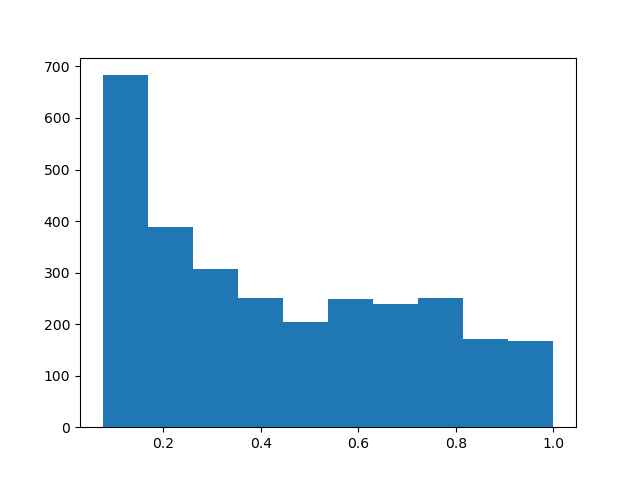

In [ ]:
fig, axs = plt.subplots()
axs.hist(cornerConfsToDescriptorWeights(corner_confs))

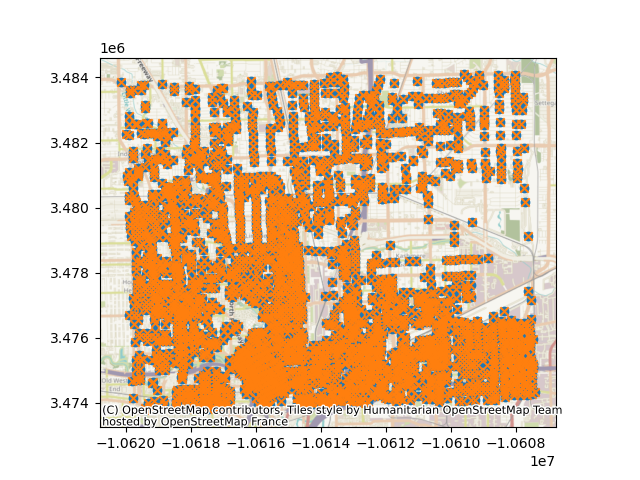

In [ ]:
fig, axs = plt.subplots()

im_corner_gdf_corrected.plot(ax=axs)
im_corner_gdf_adj.plot(ax=axs, marker='x')

cx.add_basemap(axs)


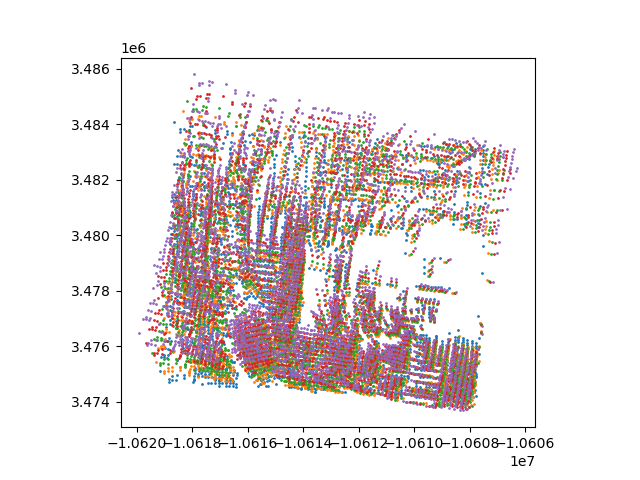

In [ ]:
fig, axs = plt.subplots()

for i in range(5):
    registration_struct['points'][i].plot(ax=axs, markersize=1)

In [ ]:
plt.plot(registration_struct['grades'])